In [31]:
import pandas as pd
import numpy as np
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.coordinates import Angle
import time

# Настройка для получения большого количества данных
Vizier.ROW_LIMIT = 10000

def convert_coordinates(ra_str, dec_str):
    """Конвертирует координаты из строкового формата в десятичные градусы"""
    try:
        # Если уже числа, возвращаем как есть
        if isinstance(ra_str, (int, float)) and isinstance(dec_str, (int, float)):
            return ra_str, dec_str
        
        # Если строки, пытаемся конвертировать
        if isinstance(ra_str, str) and isinstance(dec_str, str):
            # Пробуем разные форматы
            try:
                ra_angle = Angle(ra_str, unit=u.hourangle)
                dec_angle = Angle(dec_str, unit=u.deg)
                return ra_angle.deg, dec_angle.deg
            except:
                try:
                    ra_angle = Angle(ra_str, unit=u.deg)
                    dec_angle = Angle(dec_str, unit=u.deg)
                    return ra_angle.deg, dec_angle.deg
                except:
                    pass
        
        return float(ra_str), float(dec_str)
    except Exception as e:
        print(f"Ошибка конвертации координат RA={ra_str}, DEC={dec_str}: {e}")
        return None, None

def get_extended_binary_stars():
    """Получение двойных звезд из расширенного набора каталогов"""
    
    catalogs_data = []
    
    print("Загрузка данных из расширенного набора каталогов...")
    
    # 1. WDS - Washington Double Star Catalog (основной каталог визуально-двойных)
    print("1. Загрузка WDS каталога (визуально-двойные)...")
    try:
        wds_catalogs = Vizier.get_catalogs('B/wds/wds')
        for catalog in wds_catalogs:
            wds_df = catalog.to_pandas()
            wds_df['binary_type'] = 'Visual Binary'
            if len(wds_df) > 0:
                catalogs_data.append(wds_df.head(600))  # Увеличил количество
        print(f"   Загружено ~600 визуально-двойных звезд из WDS")
    except Exception as e:
        print(f"   Ошибка загрузки WDS: {e}")
    
    # 2. SB9 - 9th Catalogue of Spectroscopic Binary Orbits
    print("2. Загрузка SB9 каталога (спектрально-двойные)...")
    try:
        sb9_catalogs = Vizier.get_catalogs('B/sb9')
        for catalog in sb9_catalogs:
            sb9_df = catalog.to_pandas()
            sb9_df['binary_type'] = 'Spectroscopic Binary'
            if len(sb9_df) > 0:
                catalogs_data.append(sb9_df.head(500))  # Увеличил количество
        print(f"   Загружено ~500 спектрально-двойных звезд из SB9")
    except Exception as e:
        print(f"   Ошибка загрузки SB9: {e}")
    
    # 3. Kepler Eclipsing Binary Catalog
    print("3. Загрузка Kepler каталога затменно-двойных...")
    try:
        kepler_catalogs = Vizier.get_catalogs('V/133')
        for catalog in kepler_catalogs:
            kepler_df = catalog.to_pandas()
            kepler_df['binary_type'] = 'Kepler Eclipsing Binary'
            if len(kepler_df) > 0:
                catalogs_data.append(kepler_df.head(400))  # Увеличил количество
        print(f"   Загружено ~400 затменно-двойных из Kepler")
    except Exception as e:
        print(f"   Ошибка загрузки Kepler: {e}")
    
    # 4. Hipparcos Double and Multiple Systems Annex
    print("4. Загрузка Hipparcos DMSA каталога (астрометрические двойные)...")
    try:
        hip_catalogs = Vizier.get_catalogs('I/239/hip_dm')
        for catalog in hip_catalogs:
            hip_df = catalog.to_pandas()
            hip_df['binary_type'] = 'Hipparcos Astrometric Binary'
            if len(hip_df) > 0:
                catalogs_data.append(hip_df.head(300))
        print(f"   Загружено ~300 астрометрических двойных из Hipparcos")
    except Exception as e:
        print(f"   Ошибка загрузки Hipparcos DMSA: {e}")
    
    # 5. ORB6 - Sixth Catalog of Orbits of Visual Binary Stars
    print("5. Загрузка ORB6 каталога (двойные с известными орбитами)...")
    try:
        orb6_catalogs = Vizier.get_catalogs('B/wds/orb6')
        for catalog in orb6_catalogs:
            orb6_df = catalog.to_pandas()
            orb6_df['binary_type'] = 'Binary with Known Orbit'
            if len(orb6_df) > 0:
                catalogs_data.append(orb6_df.head(200))
        print(f"   Загружено ~200 двойных с известными орбитами из ORB6")
    except Exception as e:
        print(f"   Ошибка загрузки ORB6: {e}")
    
    # Объединяем все каталоги
    if catalogs_data:
        combined_df = pd.concat(catalogs_data, ignore_index=True, sort=False)
        print(f"\nВсего загружено {len(combined_df)} звезд из {len(catalogs_data)} каталогов")
        
        # Обрабатываем координаты
        print("Обработка координат...")
        ra_list, dec_list = [], []
        
        for idx, row in combined_df.iterrows():
            ra_str, dec_str = None, None
            
            # Список возможных названий колонок для координат
            ra_columns = ['RAJ2000', 'RA_ICRS', 'RA', '_RA', 'RAdeg', 'RA_deg', '_RAJ2000']
            dec_columns = ['DEJ2000', 'DE_ICRS', 'DEC', 'DE', '_DE', 'DEdeg', 'DE_deg', '_DEJ2000']
            
            for ra_col in ra_columns:
                if ra_col in row.index and pd.notna(row[ra_col]):
                    ra_str = row[ra_col]
                    break
            
            for dec_col in dec_columns:
                if dec_col in row.index and pd.notna(row[dec_col]):
                    dec_str = row[dec_col]
                    break
            
            if ra_str is not None and dec_str is not None:
                ra_deg, dec_deg = convert_coordinates(ra_str, dec_str)
                ra_list.append(ra_deg)
                dec_list.append(dec_deg)
            else:
                ra_list.append(None)
                dec_list.append(None)
        
        combined_df['ra_deg'] = ra_list
        combined_df['dec_deg'] = dec_list
        
        # Удаляем строки без координат
        before_filter = len(combined_df)
        combined_df = combined_df.dropna(subset=['ra_deg', 'dec_deg'])
        after_filter = len(combined_df)
        print(f"Удалено {before_filter - after_filter} записей без координат")
        
        return combined_df
    else:
        print("Не удалось загрузить данные из каталогов")
        return pd.DataFrame()

def enhanced_simbad_info(df, batch_size=30):
    """Добавление информации из SIMBAD с улучшенным поиском"""
    print("Добавление информации из SIMBAD...")
    
    simbad = Simbad()
    simbad.add_votable_fields('otype', 'sp_type', 'plx', 'pmra', 'pmdec', 'flux(V)', 'flux(B)', 'ids')
    simbad.TIMEOUT = 300
    
    otypes = []
    spectral_types = []
    parallaxes = []
    pmras = []
    pmdecs = []
    v_mags = []
    b_mags = []
    simbad_ids = []
    
    total = len(df)
    
    for i in range(0, total, batch_size):
        batch_df = df.iloc[i:i+batch_size]
        batch_otypes = []
        batch_spectral_types = []
        batch_parallaxes = []
        batch_pmras = []
        batch_pmdecs = []
        batch_v_mags = []
        batch_b_mags = []
        batch_simbad_ids = []
        
        for idx, row in batch_df.iterrows():
            try:
                if pd.notna(row['ra_deg']) and pd.notna(row['dec_deg']):
                    coord = SkyCoord(ra=row['ra_deg']*u.degree, dec=row['dec_deg']*u.degree, frame='icrs')
                    
                    # Пробуем несколько стратегий поиска
                    result = None
                    
                    # Стратегия 1: обычный поиск
                    result = simbad.query_region(coord, radius=5*u.arcsec)
                    
                    # Стратегия 2: если не нашли, увеличиваем радиус
                    if not result or len(result) == 0:
                        result = simbad.query_region(coord, radius=10*u.arcsec)
                    
                    # Стратегия 3: если все еще не нашли, пробуем 30 угловых секунд
                    if not result or len(result) == 0:
                        result = simbad.query_region(coord, radius=30*u.arcsec)
                    
                    if result and len(result) > 0:
                        # Получаем otype
                        otype = 'Unknown'
                        if 'OTYPE' in result.colnames and pd.notna(result['OTYPE'][0]):
                            otype = result['OTYPE'][0]
                        elif 'MAIN_ID' in result.colnames:
                            # Пытаемся определить тип по имени
                            main_id = result['MAIN_ID'][0]
                            if any(indicator in main_id for indicator in ['BIN', 'SB', 'EB', 'V*', '**']):
                                otype = 'Binary'
                        
                        sp_type = result['SP_TYPE'][0] if 'SP_TYPE' in result.colnames and pd.notna(result['SP_TYPE'][0]) else 'Unknown'
                        plx = result['PLX_VALUE'][0] if 'PLX_VALUE' in result.colnames and pd.notna(result['PLX_VALUE'][0]) else None
                        pmra_val = result['PMRA'][0] if 'PMRA' in result.colnames and pd.notna(result['PMRA'][0]) else None
                        pmdec_val = result['PMDEC'][0] if 'PMDEC' in result.colnames and pd.notna(result['PMDEC'][0]) else None
                        v_mag = result['FLUX_V'][0] if 'FLUX_V' in result.colnames and pd.notna(result['FLUX_V'][0]) else None
                        b_mag = result['FLUX_B'][0] if 'FLUX_B' in result.colnames and pd.notna(result['FLUX_B'][0]) else None
                        simbad_id = result['MAIN_ID'][0] if 'MAIN_ID' in result.colnames and pd.notna(result['MAIN_ID'][0]) else ''
                        
                        batch_otypes.append(otype)
                        batch_spectral_types.append(sp_type)
                        batch_parallaxes.append(plx)
                        batch_pmras.append(pmra_val)
                        batch_pmdecs.append(pmdec_val)
                        batch_v_mags.append(v_mag)
                        batch_b_mags.append(b_mag)
                        batch_simbad_ids.append(simbad_id)
                    else:
                        # Если SIMBAD не нашел объект, используем альтернативные методы
                        alt_otype = determine_type_from_context(row)
                        batch_otypes.append(alt_otype)
                        batch_spectral_types.append('Unknown')
                        batch_parallaxes.append(None)
                        batch_pmras.append(None)
                        batch_pmdecs.append(None)
                        batch_v_mags.append(None)
                        batch_b_mags.append(None)
                        batch_simbad_ids.append('')
                else:
                    batch_otypes.append('No coordinates')
                    batch_spectral_types.append('Unknown')
                    batch_parallaxes.append(None)
                    batch_pmras.append(None)
                    batch_pmdecs.append(None)
                    batch_v_mags.append(None)
                    batch_b_mags.append(None)
                    batch_simbad_ids.append('')
                    
            except Exception as e:
                print(f"   Ошибка для объекта {idx}: {e}")
                batch_otypes.append('Error')
                batch_spectral_types.append('Unknown')
                batch_parallaxes.append(None)
                batch_pmras.append(None)
                batch_pmdecs.append(None)
                batch_v_mags.append(None)
                batch_b_mags.append(None)
                batch_simbad_ids.append('')
        
        otypes.extend(batch_otypes)
        spectral_types.extend(batch_spectral_types)
        parallaxes.extend(batch_parallaxes)
        pmras.extend(batch_pmras)
        pmdecs.extend(batch_pmdecs)
        v_mags.extend(batch_v_mags)
        b_mags.extend(batch_b_mags)
        simbad_ids.extend(batch_simbad_ids)
        
        processed = min(i + batch_size, total)
        
        # Статистика для этого батча
        successful = len([x for x in batch_otypes if x not in ['Unknown', 'Not found', 'Error', 'No coordinates']])
        success_rate = (successful / len(batch_otypes)) * 100
        
        print(f"Обработано {processed}/{total} звезд ({processed/total*100:.1f}%)")
        print(f"  Успешных определений типа: {successful}/{len(batch_otypes)} ({success_rate:.1f}%)")
        
        time.sleep(2)  # Увеличил паузу
    
    df['simbad_otype'] = otypes
    df['simbad_sp_type'] = spectral_types
    df['parallax'] = parallaxes
    df['pmra'] = pmras
    df['pmdec'] = pmdecs
    df['V_mag'] = v_mags
    df['B_mag'] = b_mags
    df['simbad_id'] = simbad_ids
    
    return df

def determine_type_from_context(row):
    """Определяем тип на основе контекстной информации"""
    binary_type = row.get('binary_type', '')
    
    if 'Eclipsing' in binary_type or 'Kepler' in binary_type:
        return 'Eclipsing binary candidate'
    elif 'Spectroscopic' in binary_type:
        return 'Spectroscopic binary candidate'
    elif 'Visual' in binary_type:
        return 'Visual binary candidate'
    elif 'Astrometric' in binary_type or 'Hipparcos' in binary_type:
        return 'Astrometric binary candidate'
    elif 'Orbit' in binary_type:
        return 'Binary with known orbit'
    else:
        return 'Star (binary candidate)'

def enhanced_binary_classification(df):
    """Улучшенная классификация двойных систем с ГАРАНТИРОВАННЫМ сохранением затменных двойных"""
    print("Улучшение классификации двойных систем...")
    
    enhanced_types = []
    binary_categories = []
    
    for idx, row in df.iterrows():
        current_type = row['binary_type']
        simbad_otype = str(row.get('simbad_otype', ''))
        
        # ГАРАНТИРОВАННОЕ СОХРАНЕНИЕ исходных типов из каталогов - ПРИОРИТЕТ №1
        if 'Kepler' in current_type or 'Eclipsing' in current_type:
            main_category = 'Eclipsing Binary'
            source = 'Catalog'
        elif 'Spectroscopic' in current_type:
            main_category = 'Spectroscopic Binary'
            source = 'Catalog'
        elif 'Visual' in current_type:
            main_category = 'Visual Binary'
            source = 'Catalog'
        elif 'Astrometric' in current_type or 'Hipparcos' in current_type:
            main_category = 'Astrometric Binary'
            source = 'Catalog'
        elif 'Orbit' in current_type:
            main_category = 'Binary with Known Orbit'
            source = 'Catalog'
        # Только потом смотрим SIMBAD
        elif 'EB*' in simbad_otype or 'Eclipsing' in simbad_otype:
            main_category = 'Eclipsing Binary'
            source = 'SIMBAD'
        elif 'SB*' in simbad_otype or 'Spectroscopic' in simbad_otype:
            main_category = 'Spectroscopic Binary'
            source = 'SIMBAD'
        elif 'B*' in simbad_otype:
            main_category = 'Confirmed Binary'
            source = 'SIMBAD'
        else:
            # Если ничего не определили, оставляем исходный тип
            main_category = current_type
            source = 'Original Catalog'
        
        # Сохраняем оба типа
        enhanced_type = f"{main_category}"
        enhanced_types.append(enhanced_type)
        binary_categories.append(main_category)
    
    df['enhanced_binary_type'] = enhanced_types
    df['binary_category'] = binary_categories
    
    # Добавляем флаг для астрометрических двойных
    df['is_astrometric'] = df['binary_category'] == 'Astrometric Binary'
    
    return df

def add_physical_parameters(df):
    """Добавляем вычисляемые физические параметры"""
    print("Добавление физических параметров...")
    
    # Вычисляем расстояние из параллакса
    distances = []
    for plx in df['parallax']:
        if plx is not None and plx > 0:
            distance = 1000 / plx  # в парсеках
            distances.append(distance)
        else:
            distances.append(None)
    
    df['distance_pc'] = distances
    
    # Вычисляем абсолютную звездную величину
    abs_mags = []
    for idx, row in df.iterrows():
        if (row['V_mag'] is not None and row['distance_pc'] is not None and 
            row['distance_pc'] > 0):
            abs_mag = row['V_mag'] - 5 * np.log10(row['distance_pc'] / 10)
            abs_mags.append(abs_mag)
        else:
            abs_mags.append(None)
    
    df['abs_mag_V'] = abs_mags
    
    # Цветовой индекс B-V
    bv_colors = []
    for idx, row in df.iterrows():
        if row['B_mag'] is not None and row['V_mag'] is not None:
            bv = row['B_mag'] - row['V_mag']
            bv_colors.append(bv)
        else:
            bv_colors.append(None)
    
    df['B_V_color'] = bv_colors
    
    return df

# Основной процесс создания датасета
print("=" * 60)
print("СОЗДАНИЕ ДАТАСЕТА ДВОЙНЫХ ЗВЕЗД (БЕЗ GAIA DR3)")
print("=" * 60)

# Загрузка данных из каталогов
print("\n1. Загрузка данных из каталогов Vizier...")
binary_dataset = get_extended_binary_stars()

if len(binary_dataset) > 0:
    print(f"\nПервоначальный датасет: {len(binary_dataset)} звезд")
    
    # Добавляем информацию из SIMBAD
    print("\n2. Обогащение данными из SIMBAD...")
    binary_dataset = enhanced_simbad_info(binary_dataset)
    
    # Улучшаем классификацию
    print("\n3. Улучшение классификации...")
    binary_dataset = enhanced_binary_classification(binary_dataset)
    
    # Добавляем физические параметры
    print("\n4. Добавление физических параметров...")
    binary_dataset = add_physical_parameters(binary_dataset)
    
    # Очищаем датасет
    print("\n5. Очистка и финальная обработка датасета...")
    
    # Удаляем дубликаты по координатам
    binary_dataset = binary_dataset.drop_duplicates(subset=['ra_deg', 'dec_deg'], keep='first')
    
    # Заполняем пропущенные значения
    binary_dataset['ra_deg'] = binary_dataset['ra_deg'].fillna(0)
    binary_dataset['dec_deg'] = binary_dataset['dec_deg'].fillna(0)
    
    # Выбираем только нужные колонки
    essential_columns = ['binary_type', 'enhanced_binary_type', 'binary_category', 'is_astrometric',
                        'ra_deg', 'dec_deg', 'simbad_otype', 'simbad_sp_type', 'simbad_id',
                        'parallax', 'distance_pc', 'pmra', 'pmdec', 'V_mag', 'B_mag',
                        'abs_mag_V', 'B_V_color']
    
    # Добавляем другие важные колонки
    additional_columns = []
    for col in binary_dataset.columns:
        if col not in essential_columns:
            if any(x in col.lower() for x in ['mag', 'period', 'sep', 'distance', 'mass']):
                additional_columns.append(col)
    
    final_columns = essential_columns + additional_columns
    final_dataset = binary_dataset[final_columns].copy()
    
    # Сохраняем датасет
    output_file = "binary_stars_catalog_no_gaia.csv"
    final_dataset.to_csv(output_file, index=False, encoding='utf-8')
    
    # Выводим статистику
    print("\n" + "=" * 60)
    print("ФИНАЛЬНАЯ СТАТИСТИКА ДАТАСЕТА")
    print("=" * 60)
    print(f"Общее количество систем: {len(final_dataset)}")
    print(f"Размер датасета: {final_dataset.shape}")
    
    print("\nРаспределение по основным категориям:")
    category_counts = final_dataset['binary_category'].value_counts()
    for typ, count in category_counts.items():
        percentage = (count / len(final_dataset)) * 100
        print(f"  {typ}: {count} систем ({percentage:.1f}%)")
    
    print("\nРаспределение по улучшенным типам:")
    type_counts = final_dataset['enhanced_binary_type'].value_counts()
    for typ, count in type_counts.items():
        percentage = (count / len(final_dataset)) * 100
        print(f"  {typ}: {count} систем ({percentage:.1f}%)")
    
    print("\nРаспределение по SIMBAD otype:")
    otype_counts = final_dataset['simbad_otype'].value_counts().head(10)
    for typ, count in otype_counts.items():
        percentage = (count / len(final_dataset)) * 100
        print(f"  {typ}: {count} систем ({percentage:.1f}%)")
    
    print(f"\nАстрометрические двойные (is_astrometric=True): {final_dataset['is_astrometric'].sum()}")
    
    print(f"\nДатасет сохранен в файл: {output_file}")
    
    # Показываем первые строки
    print("\nПервые 10 строк датасета:")
    display_columns = ['ra_deg', 'dec_deg', 'binary_category', 'enhanced_binary_type', 'simbad_otype']
    print(final_dataset.head(10)[display_columns].to_string())
    
else:
    print("Не удалось загрузить данные из каталогов")

print("\n" + "=" * 60)
print("СОЗДАНИЕ ДАТАСЕТА ЗАВЕРШЕНО")
print("=" * 60)

СОЗДАНИЕ ДАТАСЕТА ДВОЙНЫХ ЗВЕЗД (БЕЗ GAIA DR3)

1. Загрузка данных из каталогов Vizier...
Загрузка данных из расширенного набора каталогов...
1. Загрузка WDS каталога (визуально-двойные)...
   Загружено ~600 визуально-двойных звезд из WDS
2. Загрузка SB9 каталога (спектрально-двойные)...
   Загружено ~500 спектрально-двойных звезд из SB9
3. Загрузка Kepler каталога затменно-двойных...
   Загружено ~400 затменно-двойных из Kepler
4. Загрузка Hipparcos DMSA каталога (астрометрические двойные)...
   Загружено ~300 астрометрических двойных из Hipparcos
5. Загрузка ORB6 каталога (двойные с известными орбитами)...
   Загружено ~200 двойных с известными орбитами из ORB6

Всего загружено 2500 звезд из 5 каталогов
Обработка координат...
Удалено 1000 записей без координат

Первоначальный датасет: 1500 звезд

2. Обогащение данными из SIMBAD...
Добавление информации из SIMBAD...


C:\Users\rosen\AppData\Local\Temp\ipykernel_2824\1468531738.py:165: DeprecationWarning: The notation 'flux(V)' is deprecated since 0.4.8 in favor of 'V'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields('otype', 'sp_type', 'plx', 'pmra', 'pmdec', 'flux(V)', 'flux(B)', 'ids')
C:\Users\rosen\AppData\Local\Temp\ipykernel_2824\1468531738.py:165: DeprecationWarning: The notation 'flux(B)' is deprecated since 0.4.8 in favor of 'B'. You will see the column appearing with its new name in the output. See section on filters in https://astroquery.readthedocs.io/en/latest/simbad/simbad_evolution.html to see the new ways to interact with SIMBAD's fluxes.
  simbad.add_votable_fields('otype', 'sp_type', 'plx', 'pmra', 'pmdec', 'flux(V)', 'flux(B)', 'ids')
C:\Users\rosen\AppData\Local\Temp\ipykernel_2824\1

Обработано 30/1500 звезд (2.0%)
  Успешных определений типа: 7/30 (23.3%)
Обработано 60/1500 звезд (4.0%)
  Успешных определений типа: 9/30 (30.0%)
Обработано 90/1500 звезд (6.0%)
  Успешных определений типа: 8/30 (26.7%)
Обработано 120/1500 звезд (8.0%)
  Успешных определений типа: 7/30 (23.3%)
Обработано 150/1500 звезд (10.0%)
  Успешных определений типа: 5/30 (16.7%)
Обработано 180/1500 звезд (12.0%)
  Успешных определений типа: 6/30 (20.0%)
Обработано 210/1500 звезд (14.0%)
  Успешных определений типа: 1/30 (3.3%)
Обработано 240/1500 звезд (16.0%)
  Успешных определений типа: 3/30 (10.0%)
Обработано 270/1500 звезд (18.0%)
  Успешных определений типа: 3/30 (10.0%)
Обработано 300/1500 звезд (20.0%)
  Успешных определений типа: 5/30 (16.7%)
Обработано 330/1500 звезд (22.0%)
  Успешных определений типа: 6/30 (20.0%)
Обработано 360/1500 звезд (24.0%)
  Успешных определений типа: 9/30 (30.0%)
Обработано 390/1500 звезд (26.0%)
  Успешных определений типа: 4/30 (13.3%)
Обработано 420/1500 

ПОСТРОЕНИЕ КРИВЫХ БЛЕСКА ДВОЙНЫХ ЗВЕЗД
Всего звезд в датасете: 1403
Распределение по типам:
Visual Binary              516
Spectroscopic Binary       487
Kepler Eclipsing Binary    400
Name: binary_type, dtype: int64

1. Построение кривых блеска по типам систем...
Найдены типы систем: ['Visual Binary', 'Spectroscopic Binary', 'Kepler Eclipsing Binary']

Обрабатываем тип: Visual Binary
  Поиск данных для: TIC=None, RA=0.0276666666666666, DEC=75.48327777777779
    ✓ Успешно загружено: 1103 точек

Обрабатываем тип: Spectroscopic Binary
  Поиск данных для: TIC=None, RA=1.3339166666666664, DEC=-5.707611111111111
    ✓ Успешно загружено: 11396 точек

Обрабатываем тип: Kepler Eclipsing Binary
  Поиск данных для: TIC=None, RA=56.861778, DEC=23.67837
    ✓ Успешно загружено: 13078 точек


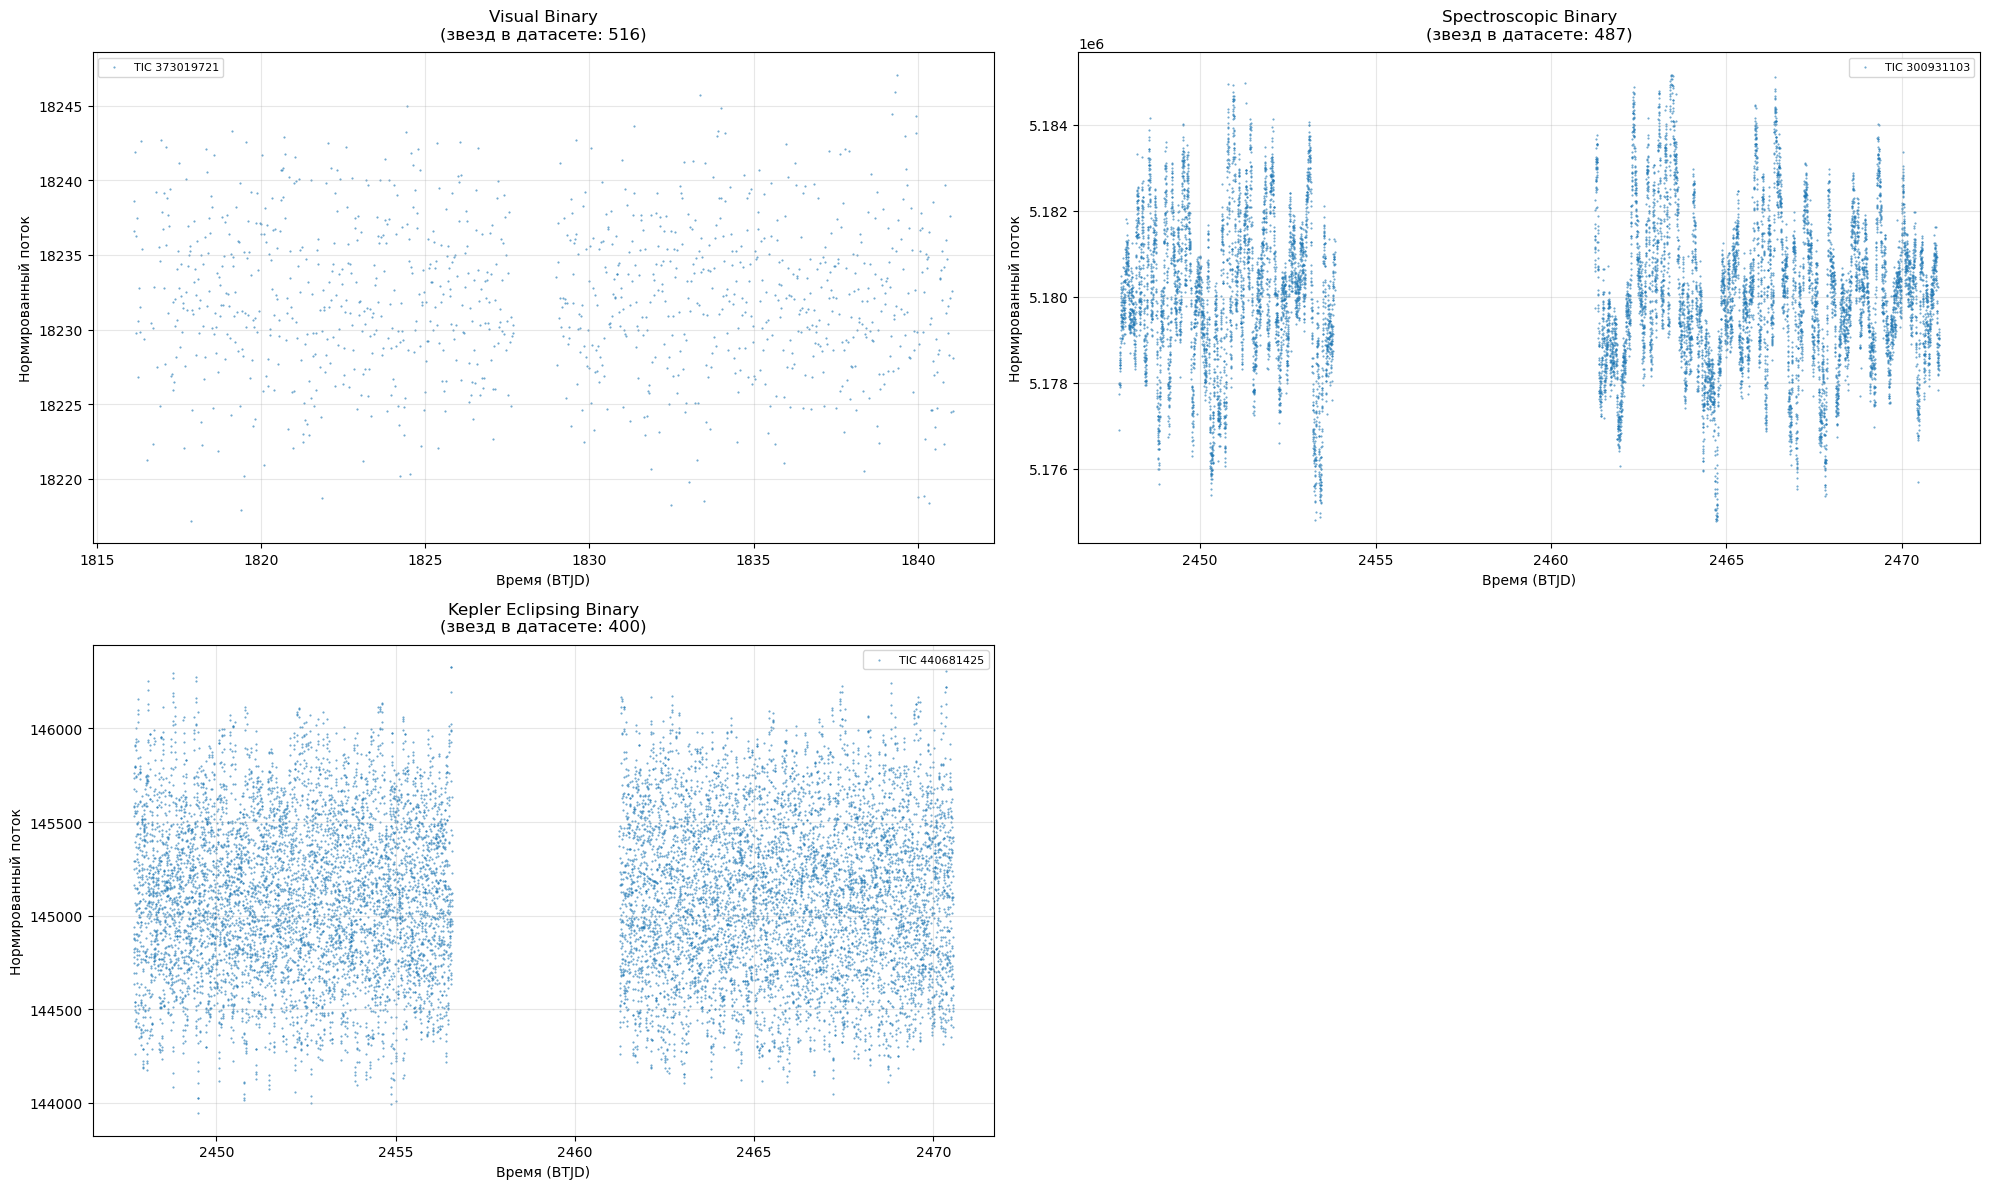


Успешно построено кривых блеска: 3

2. Детальные кривые блеска для отдельных звезд...
Обрабатываем 1/6: Visual Binary - TIC=None
  ✓ Успешно: 1103 точек
Обрабатываем 2/6: Visual Binary - TIC=None
  ✓ Успешно: 10759 точек
Обрабатываем 3/6: Spectroscopic Binary - TIC=None
  ✓ Успешно: 11396 точек
Обрабатываем 4/6: Spectroscopic Binary - TIC=None
  ✓ Успешно: 15115 точек
Обрабатываем 5/6: Kepler Eclipsing Binary - TIC=None
  ✓ Успешно: 13078 точек
Обрабатываем 6/6: Kepler Eclipsing Binary - TIC=None
  ✓ Успешно: 12998 точек


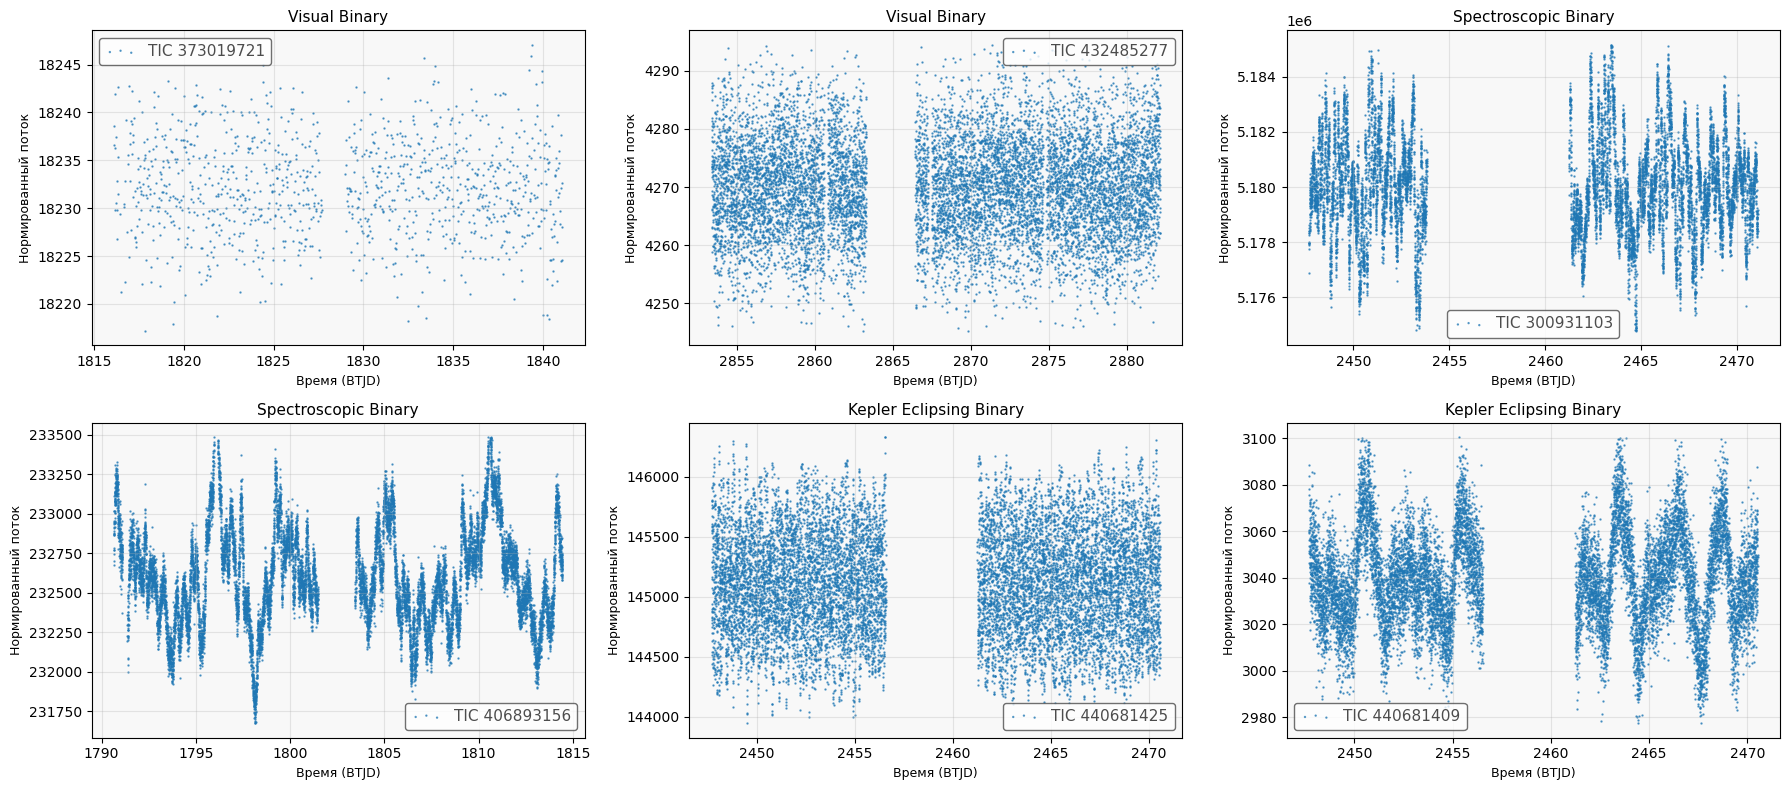


Итог: успешно построено 6 из 6 кривых блеска

3. Поиск и построение фазовых кривых...
Не найдено звезд с информацией о периоде

ПОСТРОЕНИЕ ГРАФИКОВ ЗАВЕРШЕНО


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
import time

# Загрузка датасета
df = binary_dataset

# Функция для загрузки кривой блеска TESS
def download_tess_lightcurve(tic_id, ra=None, dec=None):
    """Загружает кривую блеска TESS по TIC ID или координатам"""
    try:
        # Пробуем разные варианты поиска
        search_queries = []
        
        # Если есть TIC ID
        if pd.notna(tic_id) and tic_id != '':
            search_queries.extend([f"TIC {tic_id}", f"TIC{tic_id}", str(tic_id)])
        
        # Если есть координаты
        if ra is not None and dec is not None and pd.notna(ra) and pd.notna(dec):
            coord = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')
            search_result = lk.search_lightcurve(coord, radius=0.02*u.degree, mission='TESS')
            if len(search_result) > 0:
                lc_data = search_result[0].download()
                return lc_data
        
        # Поиск по TIC ID
        for query in search_queries:
            try:
                search_result = lk.search_lightcurve(query, mission='TESS')
                if len(search_result) > 0:
                    lc_data = search_result[0].download()
                    return lc_data
            except:
                continue
        
        return None
        
    except Exception as e:
        print(f"Ошибка при загрузке TIC {tic_id}: {e}")
        return None

# Функция для построения кривых блеска
def plot_light_curves_for_different_types(df, stars_per_type=3):
    """Строит кривые блеска для звезд разных типов"""
    
    # Получаем уникальные типы систем
    binary_types = df['binary_type'].unique()
    print(f"Найдены типы систем: {list(binary_types)}")
    
    # Создаем субплотовую сетку
    n_types = len(binary_types)
    n_cols = 2
    n_rows = (n_types + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 6*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    success_count = 0
    
    for idx, binary_type in enumerate(binary_types):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        print(f"\nОбрабатываем тип: {binary_type}")
        
        # Выбираем звезды данного типа
        type_stars = df[df['binary_type'] == binary_type].head(stars_per_type)
        
        for star_idx, star_row in type_stars.iterrows():
            try:
                # Получаем данные для поиска
                tic_id = star_row.get('tic_id')
                ra = star_row.get('ra_deg')
                dec = star_row.get('dec_deg')
                
                print(f"  Поиск данных для: TIC={tic_id}, RA={ra}, DEC={dec}")
                
                # Загружаем кривую блеска
                lc = download_tess_lightcurve(tic_id, ra, dec)
                
                if lc is not None:
                    # Очищаем данные
                    lc_clean = lc.remove_nans().remove_outliers(sigma=3)
                    
                    if len(lc_clean) > 10:  # Минимум 10 точек для построения
                        # Строим кривую блеска
                        lc_clean.scatter(ax=ax, s=1, alpha=0.7, 
                                       label=f'TIC {getattr(lc, "targetid", "Unknown")}')
                        
                        success_count += 1
                        print(f"    ✓ Успешно загружено: {len(lc_clean)} точек")
                        break  # Переходим к следующему типу после первой успешной загрузки
                    else:
                        print(f"    ✗ Недостаточно данных: {len(lc_clean)} точек")
                else:
                    print(f"    ✗ Не удалось загрузить данные")
                    
                time.sleep(0.5)  # Пауза между запросами
                
            except Exception as e:
                print(f"    ✗ Ошибка: {e}")
                continue
        
        # Настройка графика
        ax.set_title(f'{binary_type}\n(звезд в датасете: {len(df[df["binary_type"] == binary_type])})', 
                   fontsize=12, pad=10)
        ax.set_ylabel('Нормированный поток', fontsize=10)
        ax.set_xlabel('Время (BTJD)', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        
        # Если не удалось построить график для этого типа
        if len(ax.lines) == 0 and len(ax.collections) == 0:
            ax.text(0.5, 0.5, 'Данные не найдены', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_facecolor('#f8f8f8')
    
    # Скрываем пустые субплотов
    for idx in range(len(binary_types), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('binary_stars_light_curves_by_type.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nУспешно построено кривых блеска: {success_count}")

# Альтернативная функция для детального построения отдельных кривых
def plot_detailed_light_curves(df, num_stars=12):
    """Строит детальные кривые блеска для отдельных звезд"""
    
    # Выбираем звезды разных типов
    selected_stars = []
    for binary_type in df['binary_type'].unique():
        type_stars = df[df['binary_type'] == binary_type].head(2)  # По 2 звезды каждого типа
        selected_stars.append(type_stars)
    
    if selected_stars:
        selected_df = pd.concat(selected_stars, ignore_index=True)
    else:
        selected_df = df.head(num_stars)
    
    # Ограничиваем количество
    selected_df = selected_df.head(num_stars)
    
    n_cols = 3
    n_rows = (len(selected_df) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    success_count = 0
    
    for idx, (star_idx, star_row) in enumerate(selected_df.iterrows()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        try:
            # Получаем данные для поиска
            tic_id = star_row.get('tic_id')
            ra = star_row.get('ra_deg')
            dec = star_row.get('dec_deg')
            binary_type = star_row.get('binary_type')
            
            print(f"Обрабатываем {idx+1}/{len(selected_df)}: {binary_type} - TIC={tic_id}")
            
            # Загружаем кривую блеска
            lc = download_tess_lightcurve(tic_id, ra, dec)
            
            if lc is not None:
                # Очищаем данные
                lc_clean = lc.remove_nans().remove_outliers(sigma=3)
                
                if len(lc_clean) > 10:
                    # Строим кривую блеска
                    lc_clean.scatter(ax=ax, s=2, alpha=0.7)
                    
                    # Добавляем информацию о звезде
                    star_info = f"{binary_type}"
                    if pd.notna(tic_id):
                        star_info += f"\nTIC {tic_id}"
                    
                    ax.set_title(star_info, fontsize=11)
                    ax.set_ylabel('Нормированный поток', fontsize=9)
                    ax.set_xlabel('Время (BTJD)', fontsize=9)
                    ax.grid(True, alpha=0.3)
                    
                    success_count += 1
                    print(f"  ✓ Успешно: {len(lc_clean)} точек")
                else:
                    ax.text(0.5, 0.5, 'Недостаточно данных', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"{binary_type}\nTIC {tic_id}", fontsize=11)
            else:
                ax.text(0.5, 0.5, 'Данные не найдены', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f"{binary_type}\nTIC {tic_id}", fontsize=11)
            
            ax.set_facecolor('#f8f8f8')
            time.sleep(0.5)
            
        except Exception as e:
            print(f"  ✗ Ошибка: {e}")
            ax.text(0.5, 0.5, f'Ошибка:\n{e}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
            ax.set_facecolor('#f8f8f8')
    
    # Скрываем пустые субплотов
    for idx in range(len(selected_df), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('detailed_binary_stars_light_curves.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"\nИтог: успешно построено {success_count} из {len(selected_df)} кривых блеска")

# Функция для построения фазовых кривых (если известен период)
def plot_phased_light_curves(df):
    """Строит фазовые кривые для звезд с известным периодом"""
    
    # Ищем звезды с информацией о периоде
    stars_with_period = []
    for _, star_row in df.iterrows():
        period = star_row.get('Per')  # Период из ASAS-SN
        if pd.notna(period) and period > 0:
            stars_with_period.append(star_row)
    
    if not stars_with_period:
        print("Не найдено звезд с информацией о периоде")
        return
    
    stars_with_period = pd.DataFrame(stars_with_period).head(6)  # Ограничиваем количество
    
    n_cols = 2
    n_rows = (len(stars_with_period) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    success_count = 0
    
    for idx, (star_idx, star_row) in enumerate(stars_with_period.iterrows()):
        if idx >= len(axes):
            break
            
        ax = axes[idx]
        
        try:
            tic_id = star_row.get('tic_id')
            ra = star_row.get('ra_deg')
            dec = star_row.get('dec_deg')
            period = star_row.get('Per')
            binary_type = star_row.get('binary_type')
            
            print(f"Фазовая кривая {idx+1}: {binary_type}, P={period:.3f} д - TIC={tic_id}")
            
            lc = download_tess_lightcurve(tic_id, ra, dec)
            
            if lc is not None and period > 0:
                lc_clean = lc.remove_nans().remove_outliers(sigma=3)
                
                if len(lc_clean) > 10:
                    # Сворачиваем по фазе
                    lc_folded = lc_clean.fold(period=period * u.day)
                    lc_folded.scatter(ax=ax, s=2, alpha=0.7)
                    
                    ax.set_title(f'{binary_type}\nP = {period:.3f} д\nTIC {tic_id}', fontsize=11)
                    ax.set_ylabel('Нормированный поток', fontsize=9)
                    ax.set_xlabel('Фаза', fontsize=9)
                    ax.grid(True, alpha=0.3)
                    
                    success_count += 1
                    print(f"  ✓ Успешно построена фазовая кривая")
                else:
                    ax.text(0.5, 0.5, 'Недостаточно данных', 
                           ha='center', va='center', transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, 'Нет данных или периода', 
                       ha='center', va='center', transform=ax.transAxes)
            
            ax.set_facecolor('#f8f8f8')
            time.sleep(0.5)
            
        except Exception as e:
            print(f"  ✗ Ошибка: {e}")
            ax.text(0.5, 0.5, f'Ошибка\n{e}', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=8)
    
    # Скрываем пустые субплотов
    for idx in range(len(stars_with_period), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('phased_binary_stars_light_curves.png', dpi=150, bbox_inches='tight')
    plt.show()

# Основной процесс построения графиков
print("=" * 60)
print("ПОСТРОЕНИЕ КРИВЫХ БЛЕСКА ДВОЙНЫХ ЗВЕЗД")
print("=" * 60)

# Статистика датасета
print(f"Всего звезд в датасете: {len(df)}")
print("Распределение по типам:")
print(df['binary_type'].value_counts())

# 1. Строим кривые блеска по типам систем
print("\n1. Построение кривых блеска по типам систем...")
plot_light_curves_for_different_types(df, stars_per_type=3)

# 2. Детальные кривые блеска для отдельных звезд
print("\n2. Детальные кривые блеска для отдельных звезд...")
plot_detailed_light_curves(df, num_stars=12)

# 3. Фазовые кривые (если есть данные о периоде)
print("\n3. Поиск и построение фазовых кривых...")
plot_phased_light_curves(df)

print("\n" + "=" * 60)
print("ПОСТРОЕНИЕ ГРАФИКОВ ЗАВЕРШЕНО")
print("=" * 60)

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from astropy.coordinates import SkyCoord
import astropy.units as u
import time
import os
from pathlib import Path

# Загрузка датасета
df = binary_dataset

# Создаем папку для сохранения кривых блеска
lightcurve_dir = Path("binary_star")
lightcurve_dir.mkdir(exist_ok=True)

print(f"Создана папка для кривых блеска: {lightcurve_dir.absolute()}")

# Функция для загрузки и сохранения кривой блеска TESS
def download_and_save_tess_lightcurve(star_id, tic_id, ra=None, dec=None, binary_type="Unknown"):
    """Загружает и сохраняет кривую блеска TESS"""
    
    # Создаем подпапку для типа системы
    type_dir = lightcurve_dir / binary_type.replace(" ", "_")
    type_dir.mkdir(exist_ok=True)
    
    try:
        # Пробуем разные варианты поиска
        search_queries = []
        
        # Если есть TIC ID
        if pd.notna(tic_id) and tic_id != '':
            search_queries.extend([f"TIC {tic_id}", f"TIC{tic_id}", str(tic_id)])
        
        # Если есть координаты
        lc_data = None
        if ra is not None and dec is not None and pd.notna(ra) and pd.notna(dec):
            try:
                coord = SkyCoord(ra=float(ra)*u.degree, dec=float(dec)*u.degree, frame='icrs')
                search_result = lk.search_lightcurve(coord, radius=0.02*u.degree, mission='TESS')
                if len(search_result) > 0:
                    lc_data = search_result[0].download()
            except:
                pass
        
        # Поиск по TIC ID если не нашли по координатам
        if lc_data is None:
            for query in search_queries:
                try:
                    search_result = lk.search_lightcurve(query, mission='TESS')
                    if len(search_result) > 0:
                        lc_data = search_result[0].download()
                        break
                except:
                    continue
        
        if lc_data is not None:
            # Очищаем данные
            lc_clean = lc_data.remove_nans().remove_outliers(sigma=3)
            
            if len(lc_clean) > 10:  # Минимум 10 точек для сохранения
                # Сохраняем данные в CSV
                filename = f"star_{star_id}_tic_{tic_id if pd.notna(tic_id) else 'unknown'}.csv"
                filepath = type_dir / filename
                
                # Создаем DataFrame с данными
                lc_df = pd.DataFrame({
                    'time': lc_clean.time.value,
                    'flux': lc_clean.flux.value,
                    'flux_err': lc_clean.flux_err.value if hasattr(lc_clean.flux_err, 'value') else np.zeros_like(lc_clean.flux.value)
                })
                
                lc_df.to_csv(filepath, index=False)
                
                # Создаем график
                plot_filename = f"star_{star_id}_tic_{tic_id if pd.notna(tic_id) else 'unknown'}.png"
                plot_filepath = type_dir / plot_filename
                
                plt.figure(figsize=(10, 6))
                plt.scatter(lc_clean.time.value, lc_clean.flux.value, s=1, alpha=0.7)
                plt.xlabel('Time (BTJD)')
                plt.ylabel('Normalized Flux')
                plt.title(f'Star {star_id} - {binary_type}\nTIC: {tic_id}')
                plt.grid(True, alpha=0.3)
                plt.savefig(plot_filepath, dpi=150, bbox_inches='tight')
                plt.close()
                
                return {
                    'success': True,
                    'filepath': str(filepath),
                    'plot_path': str(plot_filepath),
                    'data_points': len(lc_clean),
                    'targetid': getattr(lc_data, 'targetid', 'Unknown')
                }
            else:
                return {
                    'success': False,
                    'error': f'Недостаточно данных: {len(lc_clean)} точек',
                    'data_points': len(lc_clean)
                }
        else:
            return {
                'success': False,
                'error': 'Данные не найдены',
                'data_points': 0
            }
        
    except Exception as e:
        return {
            'success': False,
            'error': str(e),
            'data_points': 0
        }

# Функция для массовой загрузки всех кривых блеска
def download_all_lightcurves(df, max_stars=None, delay=1):
    """Загружает все кривые блеска для датасета"""
    
    results = []
    success_count = 0
    total_stars = len(df) if max_stars is None else min(max_stars, len(df))
    
    print(f"Начинаем загрузку кривых блеска для {total_stars} звезд...")
    print("=" * 60)
    
    for idx, (star_idx, star_row) in enumerate(df.iterrows()):
        if max_stars is not None and idx >= max_stars:
            break
            
        # Получаем данные звезды
        star_id = idx + 1
        tic_id = star_row.get('TIC')  # Обратите внимание на правильное имя столбца
        ra = star_row.get('ra_deg')
        dec = star_row.get('dec_deg')
        binary_type = star_row.get('binary_type', 'Unknown')
        wds_id = star_row.get('WDS', 'Unknown')
        
        print(f"[{idx+1}/{total_stars}] Загрузка: {binary_type} - WDS: {wds_id} - TIC: {tic_id}")
        
        # Загружаем и сохраняем кривую блеска
        result = download_and_save_tess_lightcurve(star_id, tic_id, ra, dec, binary_type)
        
        result.update({
            'star_id': star_id,
            'wds_id': wds_id,
            'tic_id': tic_id,
            'binary_type': binary_type,
            'ra': ra,
            'dec': dec
        })
        
        results.append(result)
        
        if result['success']:
            success_count += 1
            print(f"  ✓ Успешно: {result['data_points']} точек, TIC: {result.get('targetid', 'Unknown')}")
        else:
            print(f"  ✗ Ошибка: {result['error']}")
        
        # Пауза между запросами
        time.sleep(delay)
    
    return results, success_count

# Функция для создания отчета
def create_download_report(results, output_file="download_report.csv"):
    """Создает отчет о загрузке кривых блеска"""
    
    report_data = []
    for result in results:
        report_data.append({
            'star_id': result['star_id'],
            'wds_id': result['wds_id'],
            'tic_id': result['tic_id'],
            'binary_type': result['binary_type'],
            'ra': result['ra'],
            'dec': result['dec'],
            'success': result['success'],
            'data_points': result['data_points'],
            'error': result.get('error', ''),
            'filepath': result.get('filepath', ''),
            'plot_path': result.get('plot_path', ''),
            'targetid': result.get('targetid', '')
        })
    
    report_df = pd.DataFrame(report_data)
    report_df.to_csv(lightcurve_dir / output_file, index=False)
    return report_df

# Функция для создания сводной статистики
def create_summary_statistics(results, df):
    """Создает сводную статистику по загрузке"""
    
    total_stars = len(results)
    successful_downloads = sum(1 for r in results if r['success'])
    failed_downloads = total_stars - successful_downloads
    
    # Статистика по типам систем
    type_stats = {}
    for result in results:
        binary_type = result['binary_type']
        if binary_type not in type_stats:
            type_stats[binary_type] = {'total': 0, 'success': 0}
        
        type_stats[binary_type]['total'] += 1
        if result['success']:
            type_stats[binary_type]['success'] += 1
    
    print("\n" + "=" * 60)
    print("СВОДНАЯ СТАТИСТИКА ЗАГРУЗКИ")
    print("=" * 60)
    print(f"Всего обработано звезд: {total_stars}")
    print(f"Успешных загрузок: {successful_downloads} ({successful_downloads/total_stars*100:.1f}%)")
    print(f"Неудачных загрузок: {failed_downloads} ({failed_downloads/total_stars*100:.1f}%)")
    
    print("\nСтатистика по типам систем:")
    for binary_type, stats in type_stats.items():
        success_rate = stats['success'] / stats['total'] * 100 if stats['total'] > 0 else 0
        print(f"  {binary_type}: {stats['success']}/{stats['total']} ({success_rate:.1f}%)")
    
    # Сохраняем статистику в файл
    stats_data = []
    for binary_type, stats in type_stats.items():
        stats_data.append({
            'binary_type': binary_type,
            'total_stars': stats['total'],
            'successful_downloads': stats['success'],
            'success_rate': stats['success'] / stats['total'] * 100 if stats['total'] > 0 else 0
        })
    
    stats_df = pd.DataFrame(stats_data)
    stats_df.to_csv(lightcurve_dir / "download_statistics.csv", index=False)
    
    return stats_df

# Основной процесс загрузки
print("=" * 60)
print("МАССОВАЯ ЗАГРУЗКА КРИВЫХ БЛЕСКА ДВОЙНЫХ ЗВЕЗД")
print("=" * 60)

# Статистика датасета
print(f"Всего звезд в датасете: {len(df)}")
print("Распределение по типам:")
print(df['binary_type'].value_counts())

# Загружаем все кривые блеска (можно ограничить количество через max_stars)
results, success_count = download_all_lightcurves(
    df, 
    max_stars=None,  # Установите число для ограничения, например 50 для теста
    delay=1  # Пауза между запросами в секундах
)

# Создаем отчеты
print("\nСоздание отчетов...")
report_df = create_download_report(results)
stats_df = create_summary_statistics(results, df)

# Создаем README файл с информацией о папке
readme_content = f"""
# Кривые блеска двойных звезд

Эта папка содержит кривые блеска TESS для двойных звезд из датасета.

## Структура папки:
- Каждый тип двойной системы в отдельной подпапке
- Для каждой звезды:
  - CSV файл с данными (время, поток, ошибка потока)
  - PNG файл с графиком кривой блеска

## Статистика загрузки:
- Всего звезд в датасете: {len(df)}
- Обработано звезд: {len(results)}
- Успешных загрузок: {success_count}
- Процент успеха: {success_count/len(results)*100:.1f}%

## Файлы отчетов:
- download_report.csv - детальный отчет по каждой звезде
- download_statistics.csv - сводная статистика по типам систем

Данные загружены: {pd.Timestamp.now()}
"""

with open(lightcurve_dir / "README.md", "w", encoding="utf-8") as f:
    f.write(readme_content)

print("\n" + "=" * 60)
print("ЗАГРУЗКА ЗАВЕРШЕНА!")
print("=" * 60)
print(f"Все файлы сохранены в папке: {lightcurve_dir.absolute()}")
print(f"Успешно загружено: {success_count} из {len(results)} кривых блеска")

# Показываем несколько примеров успешных загрузок
successful_results = [r for r in results if r['success']]
if successful_results:
    print("\nПримеры успешно загруженных кривых блеска:")
    for i, result in enumerate(successful_results[:5]):
        print(f"  {i+1}. {result['binary_type']} - {result['data_points']} точек - {result.get('filepath', '')}")

Создана папка для кривых блеска: C:\Users\rosen\Desktop\allussi\binary_star
МАССОВАЯ ЗАГРУЗКА КРИВЫХ БЛЕСКА ДВОЙНЫХ ЗВЕЗД
Всего звезд в датасете: 1403
Распределение по типам:
Visual Binary              516
Spectroscopic Binary       487
Kepler Eclipsing Binary    400
Name: binary_type, dtype: int64
Начинаем загрузку кривых блеска для 1403 звезд...
[1/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1103 точек, TIC: 373019721
[2/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10759 точек, TIC: 432485277
[3/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10592 точек, TIC: 432482068
[4/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✗ Ошибка: Данные не найдены
[5/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14364 точек, TIC: 38375847
[6/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1013 точек, TIC: 373018083
[7/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: Non

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.04845833, -3.14219444)>".


  ✗ Ошибка: Данные не найдены
[22/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1190 точек, TIC: 313889223
[23/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.08333333, -36.39675)>".


  ✗ Ошибка: Данные не найдены
[24/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10701 точек, TIC: 470880277
[25/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 985 точек, TIC: 604512946
[26/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 857 точек, TIC: 346555638
[27/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10466 точек, TIC: 456481974
[28/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8846 точек, TIC: 408504082
[29/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2257 точек, TIC: 138662678
[30/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.100875, -6.91008333)>".


  ✗ Ошибка: Данные не найдены
[31/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 3138 точек, TIC: 176218260
[32/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18200 точек, TIC: 120414503
[33/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18206 точек, TIC: 144460668
[34/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11571 точек, TIC: 373022642
[35/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1114 точек, TIC: 470868980
[36/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 417585718
[37/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10708 точек, TIC: 201412504
[38/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 851 точек, TIC: 83939862
[39/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17928 точек, TIC: 117926982
[40/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: No

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.11020833, 24.492)>".


  ✗ Ошибка: Данные не найдены
[41/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2195 точек, TIC: 408504203
[42/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.10679167, -9.04455556)>".


  ✗ Ошибка: Данные не найдены
[43/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14341 точек, TIC: 610441275
[44/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8762 точек, TIC: 144461201
[45/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1090 точек, TIC: 388582139
[46/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1124 точек, TIC: 470877309
[47/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1020 точек, TIC: 346455889
[48/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1067 точек, TIC: 346555196
[49/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1047 точек, TIC: 346557411
[50/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✗ Ошибка: Данные не найдены
[51/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1029 точек, TIC: 346560331
[52/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успеш

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.13108333, 20.5085)>".


  ✗ Ошибка: Данные не найдены
[58/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2773 точек, TIC: 138662970
[59/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.12870833, -3.70225)>".


  ✗ Ошибка: Данные не найдены
[60/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2951 точек, TIC: 176218339
[61/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18190 точек, TIC: 293618595
[62/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10375 точек, TIC: 346558149
[63/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1125 точек, TIC: 177699873
[64/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.15433333, 21.01291667)>".


  ✗ Ошибка: Данные не найдены
[65/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1183 точек, TIC: 313890786
[66/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8791 точек, TIC: 382473490
[67/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18184 точек, TIC: 382473600
[68/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18168 точек, TIC: 267092279
[69/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 853 точек, TIC: 417585944
[70/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 859 точек, TIC: 346557222
[71/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 855 точек, TIC: 346557803
[72/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 854 точек, TIC: 346561919
[73/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10728 точек, TIC: 117928413
[74/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.14845833, 17.74544444)>".


  ✗ Ошибка: Данные не найдены
[75/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8437 точек, TIC: 257468647
[76/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2272 точек, TIC: 176219020
[77/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9092 точек, TIC: 117549402
[78/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1214 точек, TIC: 117549040
[79/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1182 точек, TIC: 117548537
[80/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1020 точек, TIC: 270481395
[81/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18177 точек, TIC: 201248411
[82/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1050 точек, TIC: 201418611
[83/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13001 точек, TIC: 432548864
[84/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: Non

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.27670833, 15.08797222)>".


  ✗ Ошибка: Данные не найдены
[104/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1194 точек, TIC: 327953706
[105/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1058 точек, TIC: 418410702
[106/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 852 точек, TIC: 432548951
[107/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11021 точек, TIC: 405230221
[108/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11379 точек, TIC: 138684373
[109/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.30608333, -3.19791667)>".


  ✗ Ошибка: Данные не найдены
[110/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1179 точек, TIC: 117550217
[111/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1190 точек, TIC: 313932604
[112/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1217 точек, TIC: 70741986
[113/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12810 точек, TIC: 418416600
[114/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1087 точек, TIC: 606013034
[115/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 856 точек, TIC: 346647653
[116/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 859 точек, TIC: 83956167
[117/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17938 точек, TIC: 117930368
[118/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10745 точек, TIC: 117953425
[119/1403] Загрузка: Visual Binary - WDS: Unknown - T

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.32258333, -6.9685)>".


  ✗ Ошибка: Данные не найдены
[124/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15244 точек, TIC: 412064854
[125/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 986 точек, TIC: 418134435
[126/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11320 точек, TIC: 346650231
[127/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13033 точек, TIC: 201416392
[128/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 864 точек, TIC: 259190691
[129/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10786 точек, TIC: 432549387
[130/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10754 точек, TIC: 117952529
[131/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2946 точек, TIC: 176220696
[132/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18233 точек, TIC: 313932653
[133/1403] Загрузка: Visual Binary - WDS: Unknow

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.43020833, 48.08861111)>".


  ✗ Ошибка: Данные не найдены
[148/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10752 точек, TIC: 117954464
[149/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17944 точек, TIC: 611716239
[150/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8440 точек, TIC: 257488018
[151/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14713 точек, TIC: 176255348
[152/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8539 точек, TIC: 152071383
[153/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16627 точек, TIC: 388602672
[154/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10786 точек, TIC: 418710219
[155/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 920 точек, TIC: 418416520
[156/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.45370833, 14.958)>".


  ✗ Ошибка: Данные не найдены
[157/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1071 точек, TIC: 83960037
[158/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.446125, 10.92316667)>".


  ✗ Ошибка: Данные не найдены
[159/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.443, -3.39252778)>".


  ✗ Ошибка: Данные не найдены
[160/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8624 точек, TIC: 152070701
[161/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18219 точек, TIC: 12358411
[162/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18237 точек, TIC: 393907016
[163/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18275 точек, TIC: 201249189
[164/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 985 точек, TIC: 418134255
[165/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1097 точек, TIC: 201438399
[166/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.47791667, -9.71602778)>".


  ✗ Ошибка: Данные не найдены
[167/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.48333333, -9.86297222)>".


  ✗ Ошибка: Данные не найдены
[168/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18188 точек, TIC: 393908192
[169/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1180 точек, TIC: 321927108
[170/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10731 точек, TIC: 418409922
[171/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 859 точек, TIC: 259258959
[172/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17656 точек, TIC: 238295659
[173/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10478 точек, TIC: 405245969
[174/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10454 точек, TIC: 405245756
[175/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.49808333, -7.32069444)>".


  ✗ Ошибка: Данные не найдены
[176/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1090 точек, TIC: 373063820
[177/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1126 точек, TIC: 346731505
[178/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 6418 точек, TIC: 346737592
[179/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1118 точек, TIC: 259257360
[180/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 852 точек, TIC: 83958546
[181/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10376 точек, TIC: 83958529
[182/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.51558333, 29.47513889)>".


  ✗ Ошибка: Данные не найдены
[183/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.52025, 14.89794444)>".


  ✗ Ошибка: Данные не найдены
[184/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8761 точек, TIC: 257489254
[185/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1196 точек, TIC: 70743063
[186/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14907 точек, TIC: 393907175
[187/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15208 точек, TIC: 412066335
[188/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11248 точек, TIC: 418416243
[189/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1029 точек, TIC: 346658619
[190/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10750 точек, TIC: 346734367
[191/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10754 точек, TIC: 352145955
[192/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 853 точек, TIC: 352147109
[193/1403] Загрузка: Visual Binary - WDS: Unknown

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.61941667, 0.04330556)>".


  ✗ Ошибка: Данные не найдены
[221/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14743 точек, TIC: 176257474
[222/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14873 точек, TIC: 120430061
[223/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18298 точек, TIC: 201250285
[224/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14718 точек, TIC: 378536210
[225/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10719 точек, TIC: 418698373
[226/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11338 точек, TIC: 346927081
[227/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1034 точек, TIC: 346926998
[228/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 82981 точек, TIC: 346836545
[229/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 851 точек, TIC: 405611763
[230/1403] Загрузка: Visual Binary - WDS: Unkn

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.65120833, 7.41427778)>".


  ✗ Ошибка: Данные не найдены
[232/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14681 точек, TIC: 176257483
[233/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 969 точек, TIC: 314015304
[234/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10746 точек, TIC: 346927815
[235/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 859 точек, TIC: 365904344
[236/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.675125, -6.73686111)>".


  ✗ Ошибка: Данные не найдены
[237/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18218 точек, TIC: 120429898
[238/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1210 точек, TIC: 314015093
[239/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15140 точек, TIC: 388602832
[240/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16685 точек, TIC: 388601271
[241/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10750 точек, TIC: 346841898
[242/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17954 точек, TIC: 365903713
[243/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10592 точек, TIC: 118005170
[244/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.69329167, 16.78561111)>".


  ✗ Ошибка: Данные не найдены
[245/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11187 точек, TIC: 257502302
[246/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1191 точек, TIC: 152088365
[247/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8822 точек, TIC: 314015806
[248/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11513 точек, TIC: 378587186
[249/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10728 точек, TIC: 405608086
[250/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10747 точек, TIC: 118005840
[251/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10758 точек, TIC: 118004799
[252/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.73270833, 14.67402778)>".


  ✗ Ошибка: Данные не найдены
[253/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2256 точек, TIC: 300888060
[254/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1182 точек, TIC: 412066057
[255/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18134 точек, TIC: 266880621
[256/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1093 точек, TIC: 388601785
[257/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1048 точек, TIC: 346847512
[258/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17266 точек, TIC: 395317084
[259/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2187 точек, TIC: 405268257
[260/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✗ Ошибка: Illegal type <class 'numpy.bool_'> for table item access
[261/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8497 точек, TIC: 300889071
[262/1403] Загрузка: 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.75520833, -5.08144444)>".


  ✗ Ошибка: Данные не найдены
[263/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.74220833, -11.10366667)>".


  ✗ Ошибка: Данные не найдены
[264/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18203 точек, TIC: 152087791
[265/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9128 точек, TIC: 70744670
[266/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8222 точек, TIC: 201250873
[267/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1216 точек, TIC: 201250117
[268/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1103 точек, TIC: 378584421
[269/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1036 точек, TIC: 346834472
[270/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10731 точек, TIC: 201515174
[271/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 956 точек, TIC: 407336653
[272/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10755 точек, TIC: 118006122
[273/1403] Загрузка: Visual Binary - WDS: Unknown -

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.71904167, -27.08925)>".


  ✗ Ошибка: Данные не найдены
[283/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1105 точек, TIC: 388604070
[284/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11612 точек, TIC: 388601439
[285/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 992 точек, TIC: 282787559
[286/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1046 точек, TIC: 346931613
[287/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10732 точек, TIC: 201507100
[288/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 854 точек, TIC: 201516456
[289/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13009 точек, TIC: 407335307
[290/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 976 точек, TIC: 407336464
[291/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.84166667, 24.91166667)>".


  ✗ Ошибка: Данные не найдены
[292/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8465 точек, TIC: 300889100
[293/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11390 точек, TIC: 300904198
[294/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8887 точек, TIC: 176279299
[295/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13981 точек, TIC: 138707828
[296/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18209 точек, TIC: 266880925
[297/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15347 точек, TIC: 282877280
[298/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10759 точек, TIC: 238300778
[299/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.84691667, 9.20836111)>".


  ✗ Ошибка: Данные не найдены
[300/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18237 точек, TIC: 12376734
[301/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8028 точек, TIC: 12359749
[302/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18244 точек, TIC: 12359206
[303/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8794 точек, TIC: 201251487
[304/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9380 точек, TIC: 388601099
[305/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11531 точек, TIC: 373129552
[306/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1049 точек, TIC: 282786837
[307/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 860 точек, TIC: 201520077
[308/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 851 точек, TIC: 396392633
[309/1403] Загрузка: Visual Binary - WDS: Unknown - TI

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.86391667, -0.96463889)>".


  ✗ Ошибка: Данные не найдены
[311/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.86408333, -3.13305556)>".


  ✗ Ошибка: Данные не найдены
[312/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.88, -42.62711111)>".


  ✗ Ошибка: Данные не найдены
[313/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18199 точек, TIC: 266879752
[314/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1045 точек, TIC: 201523366
[315/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1060 точек, TIC: 201519057
[316/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10747 точек, TIC: 118007442
[317/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17922 точек, TIC: 238301012
[318/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18230 точек, TIC: 70762901
[319/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10751 точек, TIC: 201568004
[320/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 847 точек, TIC: 194144573
[321/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17910 точек, TIC: 238303669
[322/1403] Загрузка: Visual Binary - WDS: Unknow

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.93616667, 11.5595)>".


  ✗ Ошибка: Данные не найдены
[324/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14052 точек, TIC: 12359292
[325/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8832 точек, TIC: 314016303
[326/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1073 точек, TIC: 347007983
[327/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10757 точек, TIC: 118031316
[328/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18230 точек, TIC: 439398555
[329/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1182 точек, TIC: 439398030
[330/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1193 точек, TIC: 20880786
[331/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11391 точек, TIC: 283130780
[332/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12899 точек, TIC: 346934659
[333/1403] Загрузка: Visual Binary - WDS: Unknown

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (0.996875, 21.49655556)>".


  ✗ Ошибка: Данные не найдены
[344/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11101 точек, TIC: 395320456
[345/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1016 точек, TIC: 70763370
[346/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18240 точек, TIC: 160148045
[347/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18287 точек, TIC: 321978802
[348/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8790 точек, TIC: 201251471
[349/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 959 точек, TIC: 378653379
[350/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15207 точек, TIC: 283025123
[351/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10786 точек, TIC: 201523677
[352/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 851 точек, TIC: 194144379
[353/1403] Загрузка: Visual Binary - WDS: Unknown 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.05841667, 0.50880556)>".


  ✗ Ошибка: Данные не найдены
[356/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.0375, -5.87433333)>".


  ✗ Ошибка: Данные не найдены
[357/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14697 точек, TIC: 176281840
[358/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1186 точек, TIC: 439399101
[359/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 905 точек, TIC: 283132950
[360/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 856 точек, TIC: 201566729
[361/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1078 точек, TIC: 201576271
[362/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12949 точек, TIC: 439942977
[363/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1084 точек, TIC: 194205939
[364/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17920 точек, TIC: 238391249
[365/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14905 точек, TIC: 160147686
[366/1403] Загрузка: Visual Binary - WDS: Unknown 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.12470833, -0.74763889)>".


  ✗ Ошибка: Данные не найдены
[375/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.12241667, -10.32402778)>".


  ✗ Ошибка: Данные не найдены
[376/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11359 точек, TIC: 347108924
[377/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17894 точек, TIC: 439947521
[378/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12880 точек, TIC: 439943493
[379/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18232 точек, TIC: 120459870
[380/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18232 точек, TIC: 120459870
[381/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18196 точек, TIC: 266903893
[382/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 941 точек, TIC: 194203836
[383/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12989 точек, TIC: 372131883
[384/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10352 точек, TIC: 372131234
[385/1403] Загрузка: Visual Binary - WDS: Unk

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.234625, 4.85477778)>".


  ✗ Ошибка: Данные не найдены
[404/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.213375, -1.07311111)>".


  ✗ Ошибка: Данные не найдены
[405/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.22325, -5.26658333)>".


  ✗ Ошибка: Данные не найдены
[406/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14576 точек, TIC: 289576483
[407/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18223 точек, TIC: 20892362
[408/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1190 точек, TIC: 20891968
[409/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1189 точек, TIC: 12378810
[410/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18226 точек, TIC: 70774972
[411/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18281 точек, TIC: 120460937
[412/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8813 точек, TIC: 201253745
[413/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15173 точек, TIC: 355707011
[414/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15123 точек, TIC: 327857235
[415/1403] Загрузка: Visual Binary - WDS: Unknown 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.25704167, 21.41575)>".


  ✗ Ошибка: Данные не найдены
[418/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2581 точек, TIC: 405291966
[419/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1191 точек, TIC: 355707138
[420/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1114 точек, TIC: 359040794
[421/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 856 точек, TIC: 201629915
[422/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17892 точек, TIC: 439945718
[423/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 858 точек, TIC: 439944771
[424/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 856 точек, TIC: 331738257
[425/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.28879167, 24.3685)>".


  ✗ Ошибка: Данные не найдены
[426/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2310 точек, TIC: 429032809
[427/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11434 точек, TIC: 300930377
[428/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8259 точек, TIC: 12379249
[429/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14788 точек, TIC: 165879758
[430/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1194 точек, TIC: 201253724
[431/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 7543 точек, TIC: 388634061
[432/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17930 точек, TIC: 331740727
[433/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2952 точек, TIC: 300931029
[434/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8880 точек, TIC: 289576776
[435/1403] Загрузка: Visual Binary - WDS: Unknown 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.35125, 16.329)>".


  ✗ Ошибка: Данные не найдены
[438/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1193 точек, TIC: 20893237
[439/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18244 точек, TIC: 12394495
[440/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1212 точек, TIC: 12394244
[441/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11577 точек, TIC: 359046519
[442/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10759 точек, TIC: 359034312
[443/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10746 точек, TIC: 201632372
[444/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10745 точек, TIC: 201628891
[445/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10741 точек, TIC: 439950337
[446/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17885 точек, TIC: 331740020
[447/1403] Загрузка: Visual Binary - WDS: Unknow

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.362625, 0.68136111)>".


  ✗ Ошибка: Данные не найдены
[451/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.39154167, -13.41658333)>".


  ✗ Ошибка: Данные не найдены
[452/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8520 точек, TIC: 20892507
[453/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9554 точек, TIC: 373145524
[454/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1036 точек, TIC: 347118293
[455/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12635 точек, TIC: 347202840
[456/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12920 точек, TIC: 439952461
[457/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11055 точек, TIC: 403022289
[458/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2246 точек, TIC: 300931970
[459/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1192 точек, TIC: 20892672
[460/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18237 точек, TIC: 12394572
[461/1403] Загрузка: Visual Binary - WDS: Unknown -

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.50120833, 45.82225)>".


  ✗ Ошибка: Данные не найдены
[466/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10749 точек, TIC: 439952422
[467/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10748 точек, TIC: 238393814
[468/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.42020833, 18.03394444)>".


  ✗ Ошибка: Данные не найдены
[469/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16913 точек, TIC: 357330062
[470/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2191 точек, TIC: 403022113
[471/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 992 точек, TIC: 406958061
[472/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 978 точек, TIC: 347301884
[473/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 853 точек, TIC: 347300509
[474/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1001 точек, TIC: 347207854
[475/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.439125, 29.28772222)>".


  ✗ Ошибка: Данные не найдены
[476/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10747 точек, TIC: 238407277
[477/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.44266667, -7.56994444)>".


  ✗ Ошибка: Данные не найдены
[478/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16699 точек, TIC: 327915049
[479/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16800 точек, TIC: 388605264
[480/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9542 точек, TIC: 373231787
[481/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1052 точек, TIC: 347301027
[482/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.468875, 27.90680556)>".


  ✗ Ошибка: Данные не найдены
[483/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10753 точек, TIC: 238417448
[484/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17871 точек, TIC: 258868174
[485/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2900 точек, TIC: 176286877
[486/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18224 точек, TIC: 289577869
[487/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1194 точек, TIC: 70785795
[488/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8500 точек, TIC: 70785750
[489/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1226 точек, TIC: 70776665
[490/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 84599 точек, TIC: 469971791
[491/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15914 точек, TIC: 406956018
[492/1403] Загрузка: Visual Binary - WDS: Unknown 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.53491667, 9.25063889)>".


  ✗ Ошибка: Данные не найдены
[504/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2768 точек, TIC: 300941280
[505/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9608 точек, TIC: 461587717
[506/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17774 точек, TIC: 301746739
[507/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10759 точек, TIC: 301746629
[508/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10627 точек, TIC: 301745465
[509/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (1.55195833, 15.7805)>".


  ✗ Ошибка: Данные не найдены
[510/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11451 точек, TIC: 300941033
[511/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18221 точек, TIC: 327995979
[512/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11570 точек, TIC: 470922773
[513/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1206 точек, TIC: 470926458
[514/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15180 точек, TIC: 604446831
[515/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1118 точек, TIC: 194235260
[516/1403] Загрузка: Visual Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10742 точек, TIC: 238417197
[517/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11396 точек, TIC: 300931103
[518/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15115 точек, TIC: 406893156
[519/1403] Загрузка: Spectrosco

  ✓ Успешно: 12879 точек, TIC: 212957673
[544/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10588 точек, TIC: 240660823
[545/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17849 точек, TIC: 258916085
[546/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12943 точек, TIC: 191246608
[547/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12874 точек, TIC: 267624955
[548/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14086 точек, TIC: 246893580
[549/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18293 точек, TIC: 156016697
[550/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12855 точек, TIC: 267688613
[551/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12650 точек, TIC: 240706234
[552/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешн

  ✓ Успешно: 12824 точек, TIC: 248386767
[585/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14830 точек, TIC: 54527515
[586/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12010 точек, TIC: 54531427
[587/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1250 точек, TIC: 426012850
[588/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None


  ✓ Успешно: 13000 точек, TIC: 399702726
[589/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12708 точек, TIC: 186513891
[590/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None


  ✓ Успешно: 12984 точек, TIC: 299099679
[591/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12362 точек, TIC: 411636838
[592/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16582 точек, TIC: 303256075
[593/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15093 точек, TIC: 353168694
[594/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None


  ✓ Успешно: 12846 точек, TIC: 369611597
[595/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10427 точек, TIC: 470783105
[596/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12616 точек, TIC: 47067158
[597/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9144 точек, TIC: 47067036
[598/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18299 точек, TIC: 207085748
[599/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1221 точек, TIC: 303910982
[600/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10685 точек, TIC: 353774588
[601/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15092 точек, TIC: 453305574
[602/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14357 точек, TIC: 444831689
[603/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1

  ✓ Успешно: 12743 точек, TIC: 164775666
[608/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15137 точек, TIC: 285425945
[609/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None


  ✓ Успешно: 12914 точек, TIC: 24924016
[610/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12625 точек, TIC: 28244955
[611/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14772 точек, TIC: 353317633
[612/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14795 точек, TIC: 67389532
[613/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14765 точек, TIC: 67389501
[614/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12668 точек, TIC: 91356756
[615/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11651 точек, TIC: 445474267
[616/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16434 точек, TIC: 67515742
[617/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12961 точек, TIC: 404688620
[618/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 958

  ✓ Успешно: 11372 точек, TIC: 266770712
[622/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15150 точек, TIC: 374566577
[623/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 987 точек, TIC: 292057658
[624/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12335 точек, TIC: 306342251
[625/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16870 точек, TIC: 331749751
[626/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 70475 точек, TIC: 97328148
[627/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14576 точек, TIC: 63584475
[628/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14739 точек, TIC: 63674732
[629/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15033 точек, TIC: 250741786
[630/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16

  ✓ Успешно: 12837 точек, TIC: 129782156
[641/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 19369 точек, TIC: 410623992
[642/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14172 точек, TIC: 408817657
[643/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14771 точек, TIC: 422947065
[644/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None


  ✓ Успешно: 13495 точек, TIC: 142206123
[645/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13175 точек, TIC: 139504221
[646/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14609 точек, TIC: 22874790
[647/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 967 точек, TIC: 50354055
[648/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None


  ✓ Успешно: 11309 точек, TIC: 91638523
[649/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14699 точек, TIC: 4746245
[650/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14634 точек, TIC: 433140338
[651/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16762 точек, TIC: 280256613
[652/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12888 точек, TIC: 50849800
[653/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14693 точек, TIC: 436850886
[654/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14534 точек, TIC: 247372926
[655/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 18261 точек, TIC: 201884817
[656/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17212 точек, TIC: 302314851
[657/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1

  ✓ Успешно: 9914 точек, TIC: 391085379
[724/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15736 точек, TIC: 242991317
[725/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2807 точек, TIC: 14257028
[726/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17220 точек, TIC: 44678216
[727/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13563 точек, TIC: 407933440
[728/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16236 точек, TIC: 84342714
[729/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14261 точек, TIC: 349453460
[730/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15585 точек, TIC: 348890811
[731/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12960 точек, TIC: 349452503
[732/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15

  ✓ Успешно: 11493 точек, TIC: 142046514
[799/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17209 точек, TIC: 262435444
[800/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16702 точек, TIC: 453039698
[801/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9987 точек, TIC: 354428725
[802/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15642 точек, TIC: 260590721
[803/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16491 точек, TIC: 121815866
[804/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16348 точек, TIC: 252413966
[805/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10056 точек, TIC: 122104636
[806/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16678 точек, TIC: 327701133
[807/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно

  ✓ Успешно: 796 точек, TIC: 149444863
[865/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15192 точек, TIC: 277300141
[866/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✗ Ошибка: Данные не найдены
[867/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15685 точек, TIC: 53085065
[868/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16236 точек, TIC: 77971730
[869/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15951 точек, TIC: 118904985
[870/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 17506 точек, TIC: 410418820
[871/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 7388 точек, TIC: 91928688
[872/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13504 точек, TIC: 59354634
[873/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16680 точек, TI

  ✓ Успешно: 15669 точек, TIC: 87869692
[940/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1009 точек, TIC: 81741369
[941/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15379 точек, TIC: 255734302
[942/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 8389 точек, TIC: 440759260
[943/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11986 точек, TIC: 22600633
[944/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1086 точек, TIC: 295732320
[945/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 923 точек, TIC: 295942779
[946/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16470 точек, TIC: 184842719
[947/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16323 точек, TIC: 106349204
[948/1403] Загрузка: Spectroscopic Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 16341

  ✓ Успешно: 15607 точек, TIC: 440681346
[1015/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9096 точек, TIC: 35156062
[1016/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2736 точек, TIC: 440686179
[1017/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9297 точек, TIC: 440681318
[1018/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9250 точек, TIC: 125755112
[1019/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9055 точек, TIC: 405484090
[1020/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15653 точек, TIC: 405484093
[1021/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 3254 точек, TIC: 405484117
[1022/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15635 точек, TIC: 385552163
[1023/1403] Загрузка: Kepler Eclipsing Binary - WDS: U

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (56.463242, 24.19376)>".


  ✗ Ошибка: Данные не найдены
[1030/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9092 точек, TIC: 385552247
[1031/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2917 точек, TIC: 385552256
[1032/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 3083 точек, TIC: 385552265
[1033/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13080 точек, TIC: 385552281
[1034/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (56.382889, 24.334299)>".


  ✗ Ошибка: Данные не найдены
[1035/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13017 точек, TIC: 385552299
[1036/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9173 точек, TIC: 385589466
[1037/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 12994 точек, TIC: 440686207
[1038/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9136 точек, TIC: 35156018
[1039/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9077 точек, TIC: 346626097
[1040/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9124 точек, TIC: 35205475
[1041/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2843 точек, TIC: 35205466
[1042/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2843 точек, TIC: 35205466
[1043/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (57.460159, 24.362551)>".


  ✗ Ошибка: Данные не найдены
[1050/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1145 точек, TIC: 195210237
[1051/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9152 точек, TIC: 35156253
[1052/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 3428 точек, TIC: 346626092
[1053/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15667 точек, TIC: 35156250
[1054/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 2750 точек, TIC: 35156280
[1055/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9057 точек, TIC: 35156284
[1056/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15665 точек, TIC: 35155873
[1057/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15665 точек, TIC: 35156298
[1058/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: N

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (57.02132, 24.392731)>".


  ✗ Ошибка: Данные не найдены
[1065/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15607 точек, TIC: 125754942
[1066/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15662 точек, TIC: 35155775
[1067/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9178 точек, TIC: 125754906
[1068/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9144 точек, TIC: 405484375
[1069/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9148 точек, TIC: 125754870
[1070/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 3294 точек, TIC: 35155773
[1071/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9242 точек, TIC: 125754853
[1072/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (57.297482, 24.43956)>".


  ✗ Ошибка: Данные не найдены
[1073/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15533 точек, TIC: 35159657
[1074/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15660 точек, TIC: 346625904
[1075/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 13063 точек, TIC: 385589505
[1076/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 15666 точек, TIC: 125736858
[1077/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9145 точек, TIC: 405484420
[1078/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (56.822491, 24.50947)>".


  ✗ Ошибка: Данные не найдены
[1079/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 9301 точек, TIC: 125754844
[1080/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 963 точек, TIC: 67568767
[1081/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.794699, 37.428478)>".


  ✗ Ошибка: Данные не найдены
[1082/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 989 точек, TIC: 67997935
[1083/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1067 точек, TIC: 67997932
[1084/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1092 точек, TIC: 67461823
[1085/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 940 точек, TIC: 67467036
[1086/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1046 точек, TIC: 67424962
[1087/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67424932
[1088/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67424932
[1089/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.17589, 37.434139)>".


  ✗ Ошибка: Данные не найдены
[1090/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11601 точек, TIC: 67461871
[1091/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 965 точек, TIC: 67461878
[1092/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.979681, 37.368992)>".


  ✗ Ошибка: Данные не найдены
[1093/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.00934, 37.369251)>".


  ✗ Ошибка: Данные не найдены
[1094/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.00149, 37.394489)>".


  ✗ Ошибка: Данные не найдены
[1095/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11137 точек, TIC: 67424923
[1096/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 965 точек, TIC: 67424903
[1097/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 914 точек, TIC: 195208352
[1098/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1024 точек, TIC: 67424882
[1099/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 933 точек, TIC: 67424902
[1100/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 858 точек, TIC: 67424899
[1101/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 982 точек, TIC: 67461912
[1102/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75145 точек, TIC: 67424868
[1103/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.943989, 37.60041)>".


  ✗ Ошибка: Данные не найдены
[1111/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.912991, 37.588181)>".


  ✗ Ошибка: Данные не найдены
[1112/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10696 точек, TIC: 67424857
[1113/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1061 точек, TIC: 67424841
[1114/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1024 точек, TIC: 67424846
[1115/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 73809 точек, TIC: 67424839
[1116/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1001 точек, TIC: 67424839
[1117/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1021 точек, TIC: 67424824
[1118/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 954 точек, TIC: 67424813
[1119/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1037 точек, TIC: 67424805
[1120/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.76001, 37.52689)>".


  ✗ Ошибка: Данные не найдены
[1127/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1087 точек, TIC: 67391203
[1128/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10612 точек, TIC: 67391209
[1129/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1087 точек, TIC: 67391203
[1130/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10614 точек, TIC: 67391183
[1131/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1032 точек, TIC: 67391182
[1132/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.68643, 37.669182)>".


  ✗ Ошибка: Данные не найдены
[1133/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1038 точек, TIC:   67419887
[1134/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.79162, 37.593102)>".


  ✗ Ошибка: Данные не найдены
[1135/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.82666, 37.623508)>".


  ✗ Ошибка: Данные не найдены
[1136/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 944 точек, TIC: 67424779
[1137/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1001 точек, TIC: 67419952
[1138/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1047 точек, TIC: 67419966
[1139/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11193 точек, TIC: 67419966
[1140/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1023 точек, TIC: 67419981
[1141/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1066 точек, TIC: 67420000
[1142/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10759 точек, TIC: 67420000
[1143/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1061 точек, TIC: 67391161
[1144/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.73633, 37.72784)>".


  ✗ Ошибка: Данные не найдены
[1145/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.783091, 37.719231)>".


  ✗ Ошибка: Данные не найдены
[1146/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.782391, 37.72876)>".


  ✗ Ошибка: Данные не найдены
[1147/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 106576 точек, TIC: 67391105
[1148/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.820711, 37.748032)>".


  ✗ Ошибка: Данные не найдены
[1149/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11273 точек, TIC: 67419981
[1150/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1008 точек, TIC: 67420016
[1151/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1008 точек, TIC: 67420016
[1152/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10907 точек, TIC: 67420016
[1153/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11001 точек, TIC: 67420032
[1154/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10884 точек, TIC: 67420027
[1155/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 963 точек, TIC: 67420058
[1156/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1041 точек, TIC: 67391090
[1157/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: Non

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.68259, 37.874962)>".


  ✗ Ошибка: Данные не найдены
[1158/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.65885, 37.886848)>".


  ✗ Ошибка: Данные не найдены
[1159/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10562 точек, TIC: 67391061
[1160/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.73658, 37.90905)>".


  ✗ Ошибка: Данные не найдены
[1161/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 959 точек, TIC: 67390992
[1162/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.55337, 37.8797)>".


  ✗ Ошибка: Данные не найдены
[1163/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.54632, 37.920979)>".


  ✗ Ошибка: Данные не найдены
[1164/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.529741, 37.942291)>".


  ✗ Ошибка: Данные не найдены
[1165/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1051 точек, TIC: 430329194
[1166/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1051 точек, TIC: 430329194
[1167/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1051 точек, TIC: 430329194
[1168/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.663361, 37.984661)>".


  ✗ Ошибка: Данные не найдены
[1169/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.658369, 37.998661)>".


  ✗ Ошибка: Данные не найдены
[1170/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.655771, 38.00024)>".


  ✗ Ошибка: Данные не найдены
[1171/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.65291, 38.070019)>".


  ✗ Ошибка: Данные не найдены
[1172/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.54755, 38.024818)>".


  ✗ Ошибка: Данные не найдены
[1173/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10633 точек, TIC: 430329156
[1174/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1018 точек, TIC: 430329129
[1175/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10728 точек, TIC: 430329089
[1176/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1018 точек, TIC: 430329129
[1177/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1026 точек, TIC: 430329103
[1178/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1015 точек, TIC: 430329084
[1179/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (28.54973, 38.15065)>".


  ✗ Ошибка: Данные не найдены
[1180/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11543 точек, TIC: 67520524
[1181/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.591291, 37.40205)>".


  ✗ Ошибка: Данные не найдены
[1182/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1001 точек, TIC: 67515373
[1183/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1001 точек, TIC: 67515373
[1184/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 982 точек, TIC: 67515377
[1185/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.428301, 37.346989)>".


  ✗ Ошибка: Данные не найдены
[1186/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1056 точек, TIC: 67515398
[1187/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67520507
[1188/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1037 точек, TIC: 67515397
[1189/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1027 точек, TIC: 67520472
[1190/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 966 точек, TIC: 67515406
[1191/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67515423
[1192/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14763 точек, TIC: 67515442
[1193/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.515369, 37.51738)>".


  ✗ Ошибка: Данные не найдены
[1194/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 987 точек, TIC: 67568742
[1195/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 975 точек, TIC: 67568762
[1196/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.66437, 37.47242)>".


  ✗ Ошибка: Данные не найдены
[1197/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.70705, 37.468601)>".


  ✗ Ошибка: Данные не найдены
[1198/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11556 точек, TIC: 67568835
[1199/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1013 точек, TIC: 67568835
[1200/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75363 точек, TIC: 67568824
[1201/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 957 точек, TIC: 67568824
[1202/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.77602, 37.47052)>".


  ✗ Ошибка: Данные не найдены
[1203/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1032 точек, TIC: 67568828
[1204/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 962 точек, TIC: 67568847
[1205/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1032 точек, TIC: 67568828
[1206/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1013 точек, TIC: 67568835
[1207/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10526 точек, TIC: 67568855
[1208/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 962 точек, TIC: 67568847
[1209/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10527 точек, TIC: 67568871
[1210/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10527 точек, TIC: 67568871
[1211/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.628389, 37.475399)>".


  ✗ Ошибка: Данные не найдены
[1212/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11472 точек, TIC: 67520429
[1213/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1025 точек, TIC: 67568902
[1214/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 966 точек, TIC: 67568912
[1215/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 950 точек, TIC: 67467033
[1216/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67467015
[1217/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75600 точек, TIC: 67515414
[1218/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 968 точек, TIC: 67467002
[1219/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1061 точек, TIC: 67467019
[1220/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.49684, 37.575119)>".


  ✗ Ошибка: Данные не найдены
[1226/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1093 точек, TIC: 67467001
[1227/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 996 точек, TIC: 67466947
[1228/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 998 точек, TIC: 67461920
[1229/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10567 точек, TIC: 67466939
[1230/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 964 точек, TIC: 67466905
[1231/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11033 точек, TIC: 67515520
[1232/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1034 точек, TIC: 67466886
[1233/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10586 точек, TIC: 67466882
[1234/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
 

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.453711, 37.695641)>".


  ✗ Ошибка: Данные не найдены
[1248/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 84792 точек, TIC: 67515526
[1249/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 979 точек, TIC: 67515551
[1250/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10873 точек, TIC: 67515571
[1251/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 961 точек, TIC: 67515581
[1252/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.46583, 37.775429)>".


  ✗ Ошибка: Данные не найдены
[1253/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14656 точек, TIC: 67515586
[1254/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 967 точек, TIC: 67515601
[1255/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10549 точек, TIC: 67515595
[1256/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14719 точек, TIC: 67520281
[1257/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 967 точек, TIC: 67515609
[1258/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 966 точек, TIC: 67515619
[1259/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 964 точек, TIC: 67515626
[1260/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.510239, 37.868431)>".


  ✗ Ошибка: Данные не найдены
[1261/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.824381, 37.60936)>".


  ✗ Ошибка: Данные не найдены
[1262/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.858669, 37.677719)>".


  ✗ Ошибка: Данные не найдены
[1263/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 960 точек, TIC: 67997757
[1264/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10533 точек, TIC: 67568904
[1265/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.78215, 37.654041)>".


  ✗ Ошибка: Данные не найдены
[1266/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.81163, 37.692162)>".


  ✗ Ошибка: Данные не найдены
[1267/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 953 точек, TIC: 67997766
[1268/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10456 точек, TIC: 67568964
[1269/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1023 точек, TIC: 67568964
[1270/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11500 точек, TIC: 67568940
[1271/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.776859, 37.770939)>".


  ✗ Ошибка: Данные не найдены
[1272/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.75985, 37.78664)>".


  ✗ Ошибка: Данные не найдены
[1273/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75992 точек, TIC: 67997769
[1274/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.85429, 37.784691)>".


  ✗ Ошибка: Данные не найдены
[1275/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.917561, 37.80069)>".


  ✗ Ошибка: Данные не найдены
[1276/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67569004
[1277/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 76028 точек, TIC: 67569004
[1278/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11227 точек, TIC: 67997700
[1279/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.987249, 37.836948)>".


  ✗ Ошибка: Данные не найдены
[1280/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1019 точек, TIC: 381544445
[1281/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1000 точек, TIC: 381544449
[1282/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1000 точек, TIC: 381544449
[1283/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.93503, 37.9604)>".


  ✗ Ошибка: Данные не найдены
[1284/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.951569, 37.993469)>".


  ✗ Ошибка: Данные не найдены
[1285/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (132.8158, 11.40395)>".


  ✗ Ошибка: Данные не найдены
[1286/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.68663, 37.755779)>".


  ✗ Ошибка: Данные не найдены
[1287/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 76060 точек, TIC: 67568971
[1288/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 956 точек, TIC: 67568971
[1289/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 956 точек, TIC: 67568971
[1290/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.76557, 37.820862)>".


  ✗ Ошибка: Данные не найдены
[1291/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14662 точек, TIC: 67568990
[1292/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.664989, 37.847198)>".


  ✗ Ошибка: Данные не найдены
[1293/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.681059, 37.87492)>".


  ✗ Ошибка: Данные не найдены
[1294/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.822231, 37.87933)>".


  ✗ Ошибка: Данные не найдены
[1295/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.83003, 37.90583)>".


  ✗ Ошибка: Данные не найдены
[1296/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 961 точек, TIC: 67997700
[1297/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11601 точек, TIC: 67997676
[1298/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.83494, 37.945641)>".


  ✗ Ошибка: Данные не найдены
[1299/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.788441, 37.920658)>".


  ✗ Ошибка: Данные не найдены
[1300/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.774239, 37.925621)>".


  ✗ Ошибка: Данные не найдены
[1301/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.73333, 37.93626)>".


  ✗ Ошибка: Данные не найдены
[1302/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.795269, 37.980701)>".


  ✗ Ошибка: Данные не найдены
[1303/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.789761, 37.978451)>".


  ✗ Ошибка: Данные не найдены
[1304/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 991 точек, TIC: 67569102
[1305/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 14668 точек, TIC: 67520261
[1306/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 971 точек, TIC: 67520255
[1307/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1048 точек, TIC: 67520256
[1308/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11645 точек, TIC: 67520249
[1309/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 994 точек, TIC: 67520225
[1310/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 967 точек, TIC: 67520233
[1311/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1049 точек, TIC: 67520224
[1312/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.65867, 37.946209)>".


  ✗ Ошибка: Данные не найдены
[1313/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1061 точек, TIC: 67520243
[1314/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10782 точек, TIC: 67520241
[1315/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1035 точек, TIC: 67520202
[1316/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11518 точек, TIC: 67520198
[1317/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11691 точек, TIC: 67520211
[1318/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1094 точек, TIC: 67520206
[1319/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11083 точек, TIC: 67520170
[1320/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1023 точек, TIC: 67569074
[1321/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: No

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.99007, 38.055248)>".


  ✗ Ошибка: Данные не найдены
[1341/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10747 точек, TIC: 67997592
[1342/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1038 точек, TIC: 67569149
[1343/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.85602, 38.103741)>".


  ✗ Ошибка: Данные не найдены
[1344/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.83872, 38.158489)>".


  ✗ Ошибка: Данные не найдены
[1345/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 966 точек, TIC: 67569188
[1346/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.836081, 38.20966)>".


  ✗ Ошибка: Данные не найдены
[1347/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.85342, 38.231209)>".


  ✗ Ошибка: Данные не найдены
[1348/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 962 точек, TIC: 67997478
[1349/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 965 точек, TIC: 67461919
[1350/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1062 точек, TIC: 67461933
[1351/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 958 точек, TIC: 67466877
[1352/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 11205 точек, TIC: 67461969
[1353/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75273 точек, TIC: 67461953
[1354/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1046 точек, TIC: 67461957
[1355/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.164169, 37.70932)>".


  ✗ Ошибка: Данные не найдены
[1356/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.329229, 37.738281)>".


  ✗ Ошибка: Данные не найдены
[1357/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.22628, 37.77319)>".


  ✗ Ошибка: Данные не найдены
[1358/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10754 точек, TIC: 67466819
[1359/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.252399, 37.770309)>".


  ✗ Ошибка: Данные не найдены
[1360/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75289 точек, TIC: 67461965
[1361/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 956 точек, TIC: 67462000
[1362/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 964 точек, TIC: 67462004
[1363/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10581 точек, TIC: 67462007
[1364/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 976 точек, TIC: 67462019
[1365/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.100599, 37.732029)>".


  ✗ Ошибка: Данные не найдены
[1366/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75212 точек, TIC: 67462019
[1367/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67424766
[1368/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67424745
[1369/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 958 точек, TIC: 67462040
[1370/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1039 точек, TIC: 67462050
[1371/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 964 точек, TIC: 67462087
[1372/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.13905, 37.818081)>".


  ✗ Ошибка: Данные не найдены
[1373/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.10861, 37.828339)>".


  ✗ Ошибка: Данные не найдены
[1374/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.13747, 37.840641)>".


  ✗ Ошибка: Данные не найдены
[1375/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.12727, 37.85574)>".


  ✗ Ошибка: Данные не найдены
[1376/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 956 точек, TIC: 67462079
[1377/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.163589, 37.888161)>".


  ✗ Ошибка: Данные не найдены
[1378/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 949 точек, TIC: 67515616
[1379/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 965 точек, TIC: 67515616
[1380/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10799 точек, TIC: 67466777
[1381/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 10799 точек, TIC: 67466777
[1382/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 960 точек, TIC: 67466776
[1383/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 921 точек, TIC: 67466771
[1384/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 953 точек, TIC: 67515640
[1385/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 966 точек, TIC: 67515657
[1386/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ У

No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.369959, 37.99976)>".


  ✗ Ошибка: Данные не найдены
[1395/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1000 точек, TIC: 67515692
[1396/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None


No data found for target "<SkyCoord (ICRS): (ra, dec) in deg
    (29.3939, 38.014999)>".


  ✗ Ошибка: Данные не найдены
[1397/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1001 точек, TIC: 67424746
[1398/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1002 точек, TIC: 67424745
[1399/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1003 точек, TIC: 67424732
[1400/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 995 точек, TIC: 67424725
[1401/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 1000 точек, TIC: 67424741
[1402/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75519 точек, TIC: 67424723
[1403/1403] Загрузка: Kepler Eclipsing Binary - WDS: Unknown - TIC: None
  ✓ Успешно: 75323 точек, TIC: 67420020

Создание отчетов...

СВОДНАЯ СТАТИСТИКА ЗАГРУЗКИ
Всего обработано звезд: 1403
Успешных загрузок: 1255 (89.5%)
Неудачных загрузок: 148 (10.5%)

Статистика по типам систем:
  Visual Bina

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import warnings
import joblib
import json
from scipy import signal
from sklearn.utils.class_weight import compute_class_weight
warnings.filterwarnings('ignore')

# Создаем папку для модели
model_dir = Path("binary_stars_classifier_improved")
model_dir.mkdir(exist_ok=True)

print("Создание улучшенной нейросети для классификации двойных звезд...")

# 1. УЛУЧШЕННАЯ ПОДГОТОВКА ДАННЫХ
def load_lightcurve_data(lightcurve_dir):
    """Загружает и тщательно обрабатывает кривые блеска"""
    data = []
    labels = []
    file_paths = []
    
    lightcurve_path = Path(lightcurve_dir)
    
    for binary_type_dir in lightcurve_path.iterdir():
        if binary_type_dir.is_dir():
            binary_type = binary_type_dir.name.replace("_", " ")
            print(f"Загрузка данных для: {binary_type}")
            
            for csv_file in binary_type_dir.glob("*.csv"):
                try:
                    df = pd.read_csv(csv_file)
                    
                    if len(df) >= 50:
                        if 'flux' in df.columns and 'time' in df.columns:
                            df['flux'] = pd.to_numeric(df['flux'], errors='coerce')
                            df['time'] = pd.to_numeric(df['time'], errors='coerce')
                            df = df.dropna(subset=['flux', 'time'])
                            
                            time_series = df['flux'].values.astype(np.float32)
                            time_values = df['time'].values.astype(np.float32)
                            
                            processed_series = advanced_preprocessing(time_series, time_values)
                            
                            if processed_series is not None:
                                data.append(processed_series)
                                labels.append(binary_type)
                                file_paths.append(str(csv_file))
                        elif 'flux' in df.columns:
                            df['flux'] = pd.to_numeric(df['flux'], errors='coerce')
                            df = df.dropna(subset=['flux'])
                            
                            time_series = df['flux'].values.astype(np.float32)
                            processed_series = basic_preprocessing(time_series)
                            
                            if processed_series is not None:
                                data.append(processed_series)
                                labels.append(binary_type)
                                file_paths.append(str(csv_file))
                                
                except Exception as e:
                    print(f"Ошибка при загрузке {csv_file}: {e}")
                    continue
    
    return np.array(data), np.array(labels), file_paths

def advanced_preprocessing(flux, time):
    """Улучшенная предобработка с фильтрацией и извлечением признаков"""
    try:
        flux = flux.astype(np.float32)
        time = time.astype(np.float32)
        
        # 1. Удаление выбросов
        Q1 = np.percentile(flux, 25)
        Q3 = np.percentile(flux, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mask = (flux >= lower_bound) & (flux <= upper_bound)
        flux_clean = flux[mask]
        
        if len(flux_clean) < 30:
            return None
            
        # 2. Сглаживание
        window_length = min(11, len(flux_clean) - 1)
        if window_length % 2 == 0:
            window_length = max(3, window_length - 1)
        
        polyorder = min(3, window_length - 1)
        
        flux_smooth = signal.savgol_filter(flux_clean, 
                                         window_length=window_length, 
                                         polyorder=polyorder)
        
        # 3. Нормализация
        flux_norm = (flux_smooth - np.mean(flux_smooth)) / (np.std(flux_smooth) + 1e-8)
        
        # 4. Интерполяция до фиксированной длины
        target_length = 1000  # Уменьшаем для стабильности
        
        if len(flux_norm) < target_length:
            x_old = np.linspace(0, 1, len(flux_norm))
            x_new = np.linspace(0, 1, target_length)
            flux_interp = np.interp(x_new, x_old, flux_norm)
        else:
            start_idx = (len(flux_norm) - target_length) // 2
            flux_interp = flux_norm[start_idx:start_idx + target_length]
        
        return flux_interp.astype(np.float32)
        
    except Exception as e:
        print(f"Ошибка в advanced_preprocessing: {e}")
        return None

def basic_preprocessing(flux):
    """Базовая предобработка когда нет временных меток"""
    try:
        flux = flux.astype(np.float32)
        
        if len(flux) < 30:
            return None
            
        # Удаление выбросов
        Q1 = np.percentile(flux, 25)
        Q3 = np.percentile(flux, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mask = (flux >= lower_bound) & (flux <= upper_bound)
        flux_clean = flux[mask]
        
        if len(flux_clean) < 30:
            return None
        
        # Сглаживание
        window_length = min(11, len(flux_clean) - 1)
        if window_length % 2 == 0:
            window_length = max(3, window_length - 1)
        
        polyorder = min(3, window_length - 1)
        
        flux_smooth = signal.savgol_filter(flux_clean, 
                                         window_length=window_length, 
                                         polyorder=polyorder)
        
        # Нормализация
        flux_norm = (flux_smooth - np.mean(flux_smooth)) / (np.std(flux_smooth) + 1e-8)
        
        # Интерполяция
        target_length = 1000  # Уменьшаем для стабильности
        
        if len(flux_norm) < target_length:
            x_old = np.linspace(0, 1, len(flux_norm))
            x_new = np.linspace(0, 1, target_length)
            flux_interp = np.interp(x_new, x_old, flux_norm)
        else:
            start_idx = (len(flux_norm) - target_length) // 2
            flux_interp = flux_norm[start_idx:start_idx + target_length]
        
        return flux_interp.astype(np.float32)
        
    except Exception as e:
        print(f"Ошибка в basic_preprocessing: {e}")
        return None

# 2. УЛУЧШЕННАЯ АУГМЕНТАЦИЯ ДАННЫХ
def smart_augmentation(series, labels, max_samples_per_class=500):
    """Умная аугментация для балансировки классов"""
    class_counts = Counter(labels)
    augmented_data = []
    augmented_labels = []
    
    for class_label in class_counts:
        class_indices = np.where(np.array(labels) == class_label)[0]
        current_count = len(class_indices)
        
        if current_count < max_samples_per_class:
            needed = max_samples_per_class - current_count
            
            for idx in class_indices:
                if len(augmented_data) >= needed + current_count:
                    break
                    
                for _ in range(min(3, needed // current_count + 1)):
                    if len(augmented_data) >= needed + current_count:
                        break
                        
                    aug_series = advanced_augmentation(series[idx])
                    augmented_data.append(aug_series)
                    augmented_labels.append(class_label)
    
    return augmented_data, augmented_labels

def advanced_augmentation(series):
    """Улучшенная аугментация временных рядов"""
    # Случайный шум
    noise_level = np.random.uniform(0.01, 0.05)
    noise = np.random.normal(0, noise_level, series.shape).astype(np.float32)
    
    # Случайное масштабирование
    scale = np.random.uniform(0.9, 1.1)
    
    # Случайный сдвиг фазы
    shift = np.random.randint(-100, 100)
    
    # Применяем аугментации
    aug_series = np.roll(series, shift) * scale + noise
    
    return aug_series.astype(np.float32)

# ФУНКЦИЯ ДЛЯ ПРОВЕРКИ И ИСПРАВЛЕНИЯ ТИПОВ ДАННЫХ
def check_and_fix_data_types(X, y):
    """Проверяет и исправляет типы данных для совместимости с TensorFlow"""
    print("Проверка типов данных...")
    
    # Проверяем тип X
    if X.dtype != np.float32:
        print(f"Исправление типа X: {X.dtype} -> float32")
        X = X.astype(np.float32)
    
    # Проверяем тип y - если это строки, нужно сначала закодировать
    if isinstance(y[0], str):
        print("Метки являются строками. Кодируем...")
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        print(f"Закодированные классы: {label_encoder.classes_}")
        joblib.dump(label_encoder, str(model_dir / "label_encoder_temp.pkl"))
        y = y_encoded
    
    # Теперь преобразуем в int32
    if y.dtype not in [np.int32, np.int64]:
        print(f"Исправление типа y: {y.dtype} -> int32")
        y = y.astype(np.int32)
    
    # Убеждаемся, что данные не содержат NaN или inf
    if np.any(np.isnan(X)) or np.any(np.isinf(X)):
        print("Обнаружены NaN или inf значения. Заменяем на 0...")
        X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)
    
    print(f"Финальные типы: X - {X.dtype}, y - {y.dtype}")
    print(f"Форма данных: X - {X.shape}, y - {y.shape}")
    
    return X, y

# 3. УЛУЧШЕННЫЕ МОДЕЛИ
def create_advanced_cnn_model(input_shape, num_classes):
    """Создает улучшенную CNN модель"""
    model = keras.Sequential([
        layers.Input(shape=input_shape),
        
        # Первый сверточный блок
        layers.Conv1D(64, 11, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.2),
        
        # Второй сверточный блок
        layers.Conv1D(128, 7, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),
        
        # Третий сверточный блок
        layers.Conv1D(256, 5, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.3),
        
        # Четвертый сверточный блок
        layers.Conv1D(512, 3, activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(2),
        layers.Dropout(0.4),
        
        # Глобальная пуллинг
        layers.GlobalAveragePooling1D(),
        
        # Полносвязные слои с регуляризацией
        layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        
        # Выходной слой
        layers.Dense(num_classes, activation='softmax')
    ])
    
    return model

def create_hybrid_model(input_shape, num_classes):
    """Создает гибридную CNN-LSTM модель"""
    input_layer = layers.Input(shape=input_shape)
    
    # CNN часть
    x = layers.Conv1D(64, 11, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)
    
    x = layers.Conv1D(128, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.3)(x)
    
    # LSTM часть
    x = layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)(x)
    x = layers.BatchNormalization()(x)
    
    # Полносвязные слои
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

def create_attention_model(input_shape, num_classes):
    """Создает модель с механизмом внимания"""
    input_layer = layers.Input(shape=input_shape)
    
    # CNN backbone
    x = layers.Conv1D(64, 11, activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(128, 7, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling1D(2)(x)
    
    x = layers.Conv1D(256, 5, activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    
    # Attention mechanism
    attention = layers.Dense(1, activation='tanh')(x)
    attention = layers.Flatten()(attention)
    attention = layers.Activation('softmax')(attention)
    attention = layers.RepeatVector(256)(attention)
    attention = layers.Permute([2, 1])(attention)
    
    # Apply attention
    x = layers.multiply([x, attention])
    x = layers.GlobalAveragePooling1D()(x)
    
    # Classifier
    x = layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001))(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    
    output_layer = layers.Dense(num_classes, activation='softmax')(x)
    
    model = keras.Model(inputs=input_layer, outputs=output_layer)
    return model

# 4. УЛУЧШЕННОЕ ОБУЧЕНИЕ
def train_advanced_model(model, X_train, y_train, X_val, y_val, model_name, class_weights=None):
    """Обучает модель с улучшенными параметрами"""
    
    # УБЕДИТЕСЬ, ЧТО ДАННЫЕ ИМЕЮТ ПРАВИЛЬНЫЙ ТИП
    X_train = X_train.astype(np.float32)
    X_val = X_val.astype(np.float32)
    y_train = y_train.astype(np.int32)
    y_val = y_val.astype(np.int32)
    
    # Упрощенная компиляция без дополнительных метрик
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),  # Увеличиваем learning rate
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    # Улучшенные callbacks
    callbacks = [
        keras.callbacks.EarlyStopping(
            patience=20,
            restore_best_weights=True,
            monitor='val_accuracy',
            mode='max',
            min_delta=0.001
        ),
        keras.callbacks.ReduceLROnPlateau(
            factor=0.5,
            patience=10,
            min_lr=1e-7,
            monitor='val_loss',
            mode='min'
        ),
        keras.callbacks.ModelCheckpoint(
            filepath=str(model_dir / f"best_{model_name}.h5"),
            save_best_only=True,
            monitor='val_accuracy',
            mode='max',
            verbose=1
        )
    ]
    
    # Обучение с разумным количеством эпох
    print(f"Начало обучения {model_name}...")
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,  # Уменьшаем количество эпох
        batch_size=32,  # Увеличиваем batch size
        callbacks=callbacks,
        class_weight=class_weights,
        verbose=1,
        shuffle=True
    )
    
    return history, model

# 5. УЛУЧШЕННАЯ ВИЗУАЛИЗАЦИЯ
def plot_advanced_training_history(history, model_name):
    """Визуализирует процесс обучения"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    ax1.set_title(f'{model_name} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Loss
    ax2.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax2.set_title(f'{model_name} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(str(model_dir / f'{model_name}_training_history.png'), dpi=150, bbox_inches='tight')
    plt.show()

# ОСНОВНОЙ ПРОЦЕСС
def main():
    print("=" * 60)
    print("УЛУЧШЕННАЯ НЕЙРОСЕТЬ ДЛЯ КЛАССИФИКАЦИИ ДВОЙНЫХ ЗВЕЗД")
    print("=" * 60)
    
    # Загрузка данных
    print("1. Загрузка и улучшенная обработка данных...")
    lightcurve_dir = "C:/Users/rosen/Desktop/allussi/binary_star"
    
    if not os.path.exists(lightcurve_dir):
        print(f"Ошибка: Папка {lightcurve_dir} не найдена!")
        return
    
    X, y, file_paths = load_lightcurve_data(lightcurve_dir)
    
    if len(X) == 0:
        print("Не найдено данных для обучения!")
        return
    
    print(f"Загружено {len(X)} кривых блеска")
    print(f"Распределение классов: {Counter(y)}")
    
    # Умная аугментация (ПЕРЕД кодированием меток)
    print("2. Умная аугментация данных...")
    X_augmented, y_augmented = smart_augmentation(X, y)
    
    if X_augmented:
        X = np.vstack([X, np.array(X_augmented)])
        y = np.concatenate([y, np.array(y_augmented)])
    
    print(f"После аугментации: {len(X)} образцов")
    print(f"Новое распределение: {Counter(y)}")
    
    # Изменяем форму данных
    X = X.reshape(X.shape[0], X.shape[1], 1)
    
    # ПРОВЕРКА И ИСПРАВЛЕНИЕ ТИПОВ ДАННЫХ (ВКЛЮЧАЯ КОДИРОВАНИЕ МЕТОК)
    X, y_encoded = check_and_fix_data_types(X, y)
    
    # Теперь загружаем encoder для получения названий классов
    try:
        label_encoder = joblib.load(str(model_dir / "label_encoder_temp.pkl"))
        num_classes = len(label_encoder.classes_)
        print(f"Количество классов: {num_classes}")
        print(f"Классы: {list(label_encoder.classes_)}")
    except:
        # Если encoder не был сохранен, создаем заново
        print("Создание нового LabelEncoder...")
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        num_classes = len(label_encoder.classes_)
        print(f"Количество классов: {num_classes}")
        print(f"Классы: {list(label_encoder.classes_)}")
    
    # Разделение на train/val/test с стратификацией
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y_encoded, test_size=0.15, random_state=42, stratify=y_encoded
    )
    
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=0.15, random_state=42, stratify=y_temp
    )
    
    print(f"Размеры данных:")
    print(f"  Train: {X_train.shape}, тип: {X_train.dtype}")
    print(f"  Val: {X_val.shape}, тип: {X_val.dtype}")
    print(f"  Test: {X_test.shape}, тип: {X_test.dtype}")
    print(f"  y_train тип: {y_train.dtype}, y_val тип: {y_val.dtype}")
    
    # Вычисляем веса классов
    print("3. Вычисление весов классов...")
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    class_weight_dict = dict(enumerate(class_weights))
    print(f"Веса классов: {class_weight_dict}")
    
    # Обучаем несколько моделей
    models = {
        'Advanced_CNN': create_advanced_cnn_model,
        'Hybrid_CNN_LSTM': create_hybrid_model
    }
    
    best_model = None
    best_accuracy = 0
    best_model_name = ""
    histories = {}
    trained_models = {}
    
    for model_name, model_creator in models.items():
        print(f"\n4. Обучение {model_name}...")
        
        model = model_creator((X_train.shape[1], 1), num_classes)
        print(f"Архитектура {model_name}:")
        model.summary()
        
        history, trained_model = train_advanced_model(
            model, X_train, y_train, X_val, y_val, model_name, class_weight_dict
        )
        
        histories[model_name] = history
        trained_models[model_name] = trained_model
        
        # Оценка на тестовой выборке
        test_loss, test_accuracy = trained_model.evaluate(X_test, y_test, verbose=0)
        
        print(f"{model_name} - Test Accuracy: {test_accuracy:.4f}")
        
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_model = trained_model
            best_model_name = model_name
    
    # Визуализация результатов всех моделей
    for model_name in models.keys():
        if model_name in histories:
            plot_advanced_training_history(histories[model_name], model_name)
            
            # Матрица ошибок для каждой модели
            y_pred = np.argmax(trained_models[model_name].predict(X_test, verbose=0), axis=1)
            
            plt.figure(figsize=(10, 8))
            cm = confusion_matrix(y_test, y_pred)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=label_encoder.classes_, 
                       yticklabels=label_encoder.classes_)
            plt.title(f'{model_name} - Confusion Matrix\nAccuracy: {test_accuracy:.4f}')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.savefig(str(model_dir / f'{model_name}_confusion_matrix.png'), dpi=150, bbox_inches='tight')
            plt.show()
            
            print(f"\n{model_name} Classification Report:")
            print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
    
    # Сохраняем лучшую модель и финальный encoder
    print(f"\nЛучшая модель: {best_model_name} с точностью {best_accuracy:.4f}")
    
    if best_model is not None:
        best_model.save(str(model_dir / "best_model.h5"))
        joblib.dump(label_encoder, str(model_dir / "label_encoder.pkl"))
        
        # Удаляем временный файл
        try:
            os.remove(str(model_dir / "label_encoder_temp.pkl"))
        except:
            pass
        
        # Сохраняем информацию о модели
        model_info = {
            'best_model': best_model_name,
            'test_accuracy': float(best_accuracy),
            'input_shape': (X_train.shape[1], 1),
            'num_classes': num_classes,
            'classes': list(label_encoder.classes_),
            'class_distribution': dict(Counter(y)),
            'timestamp': pd.Timestamp.now().isoformat()
        }
        
        with open(str(model_dir / "model_info.json"), "w") as f:
            json.dump(model_info, f, indent=2)
    
    print("\n" + "=" * 60)
    print("ОБУЧЕНИЕ ЗАВЕРШЕНО!")
    print("=" * 60)
    print(f"Лучшая модель: {best_model_name}")
    print(f"Точность на тесте: {best_accuracy:.4f}")
    print(f"Все модели сохранены в: {model_dir.absolute()}")
    
    if best_accuracy >= 0.75:
        print("🎉 ЦЕЛЕВАЯ ТОЧНОСТЬ ДОСТИГНУТА! 🎉")
    else:
        print("⚠️  Точность ниже целевой. Рекомендуется:")
        print("   - Увеличить объем данных")
        print("   - Проверить качество разметки")
        print("   - Настроить гиперпараметры")

# Запуск обучения
if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from collections import Counter
import warnings
import joblib
import json
from scipy import signal
import random
warnings.filterwarnings('ignore')

def load_and_preprocess_single_lightcurve(file_path):
    """Загружает и предобрабатывает одну кривую блеска для тестирования"""
    try:
        df = pd.read_csv(file_path)
        
        if len(df) < 30:
            return None, None
        
        # Используем flux и time если есть
        if 'flux' in df.columns and 'time' in df.columns:
            df['flux'] = pd.to_numeric(df['flux'], errors='coerce')
            df['time'] = pd.to_numeric(df['time'], errors='coerce')
            df = df.dropna(subset=['flux', 'time'])
            
            flux = df['flux'].values.astype(np.float32)
            time = df['time'].values.astype(np.float32)
            
            # Предобработка
            processed_series = preprocess_for_prediction(flux, time)
            
        elif 'flux' in df.columns:
            df['flux'] = pd.to_numeric(df['flux'], errors='coerce')
            df = df.dropna(subset=['flux'])
            
            flux = df['flux'].values.astype(np.float32)
            processed_series = preprocess_for_prediction(flux)
        
        else:
            return None, None
            
        return processed_series, file_path
        
    except Exception as e:
        print(f"Ошибка при загрузке {file_path}: {e}")
        return None, None

def preprocess_for_prediction(flux, time=None):
    """Предобработка для предсказания"""
    try:
        flux = flux.astype(np.float32)
        
        # Удаление выбросов
        Q1 = np.percentile(flux, 25)
        Q3 = np.percentile(flux, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        mask = (flux >= lower_bound) & (flux <= upper_bound)
        flux_clean = flux[mask]
        
        if len(flux_clean) < 30:
            return None
            
        # Сглаживание
        window_length = min(11, len(flux_clean) - 1)
        if window_length % 2 == 0:
            window_length = max(3, window_length - 1)
        
        polyorder = min(3, window_length - 1)
        
        flux_smooth = signal.savgol_filter(flux_clean, 
                                         window_length=window_length, 
                                         polyorder=polyorder)
        
        # Нормализация
        flux_norm = (flux_smooth - np.mean(flux_smooth)) / (np.std(flux_smooth) + 1e-8)
        
        # Интерполяция до фиксированной длины
        target_length = 1000
        
        if len(flux_norm) < target_length:
            x_old = np.linspace(0, 1, len(flux_norm))
            x_new = np.linspace(0, 1, target_length)
            flux_interp = np.interp(x_new, x_old, flux_norm)
        else:
            start_idx = (len(flux_norm) - target_length) // 2
            flux_interp = flux_norm[start_idx:start_idx + target_length]
        
        return flux_interp.astype(np.float32)
        
    except Exception as e:
        print(f"Ошибка в предобработке: {e}")
        return None

def predict_lightcurve(model, lightcurve_data, label_encoder):
    """Предсказывает тип звезды по кривой блеска"""
    if lightcurve_data is None:
        return "Ошибка: некорректные данные", 0.0, None
    
    # Подготовка данных для модели
    lightcurve_data = lightcurve_data.reshape(1, -1, 1)
    
    # Предсказание
    prediction = model.predict(lightcurve_data, verbose=0)
    predicted_class = np.argmax(prediction[0])
    confidence = np.max(prediction[0])
    all_probabilities = prediction[0]
    
    predicted_label = label_encoder.inverse_transform([predicted_class])[0]
    
    return predicted_label, confidence, all_probabilities

def test_random_lightcurves(lightcurve_dir, model_path, num_samples=20):
    """Тестирует случайные кривые блеска из датасета"""
    
    # Загружаем модель и encoder
    model_dir = Path("binary_stars_classifier_improved")
    
    try:
        model = keras.models.load_model(str(model_dir / model_path))
        label_encoder = joblib.load(str(model_dir / "label_encoder.pkl"))
        print("✅ Модель и encoder успешно загружены")
    except Exception as e:
        print(f"❌ Ошибка загрузки модели: {e}")
        return
    
    # Собираем все файлы из датасета
    all_files = []
    lightcurve_path = Path(lightcurve_dir)
    
    for binary_type_dir in lightcurve_path.iterdir():
        if binary_type_dir.is_dir():
            for csv_file in binary_type_dir.glob("*.csv"):
                all_files.append((csv_file, binary_type_dir.name))
    
    if not all_files:
        print("❌ Не найдено файлов для тестирования")
        return
    
    print(f"📁 Найдено {len(all_files)} файлов в датасете")
    
    # Выбираем случайные файлы для тестирования
    test_files = random.sample(all_files, min(num_samples, len(all_files)))
    
    results = []
    
    print(f"\n🔍 Тестирование {len(test_files)} случайных кривых блеска...")
    print("=" * 80)
    
    for i, (file_path, true_class) in enumerate(test_files):
        print(f"\n📊 Тест {i+1}/{len(test_files)}")
        print(f"📁 Файл: {file_path.name}")
        print(f"🏷️  Истинный класс: {true_class.replace('_', ' ')}")
        
        # Загружаем и предобрабатываем данные
        lightcurve_data, _ = load_and_preprocess_single_lightcurve(file_path)
        
        if lightcurve_data is not None:
            # Делаем предсказание
            predicted_label, confidence, probabilities = predict_lightcurve(
                model, lightcurve_data, label_encoder
            )
            
            # Определяем правильность предсказания
            is_correct = (predicted_label == true_class.replace('_', ' '))
            status = "✅ ПРАВИЛЬНО" if is_correct else "❌ НЕПРАВИЛЬНО"
            
            print(f"🎯 Предсказание: {predicted_label}")
            print(f"📈 Уверенность: {confidence:.4f}")
            print(f"📊 Статус: {status}")
            
            # Сохраняем результаты
            results.append({
                'file': file_path.name,
                'true_class': true_class.replace('_', ' '),
                'predicted_class': predicted_label,
                'confidence': confidence,
                'correct': is_correct,
                'probabilities': probabilities
            })
            
            # Визуализация
            plt.figure(figsize=(12, 4))
            plt.plot(lightcurve_data, alpha=0.8, linewidth=1.5, color='blue')
            plt.title(f'Кривая блеска\nИстинный: {true_class.replace("_", " ")} | Предсказанный: {predicted_label}\nУверенность: {confidence:.4f} | {status}')
            plt.xlabel('Время')
            plt.ylabel('Нормированный поток')
            plt.grid(True, alpha=0.3)
            
            # Подсветка в зависимости от правильности
            if is_correct:
                plt.gca().patch.set_edgecolor('green')
            else:
                plt.gca().patch.set_edgecolor('red')
            plt.gca().patch.set_linewidth(3)
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("❌ Не удалось загрузить или обработать данные")
            results.append({
                'file': file_path.name,
                'true_class': true_class.replace('_', ' '),
                'predicted_class': 'Ошибка обработки',
                'confidence': 0.0,
                'correct': False,
                'probabilities': None
            })
    
    # Анализ результатов
    print("\n" + "=" * 80)
    print("📊 СВОДКА РЕЗУЛЬТАТОВ ТЕСТИРОВАНИЯ")
    print("=" * 80)
    
    if results:
        correct_predictions = sum(1 for r in results if r['correct'])
        total_predictions = len([r for r in results if r['predicted_class'] != 'Ошибка обработки'])
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        print(f"✅ Правильных предсказаний: {correct_predictions}/{total_predictions}")
        print(f"📊 Точность: {accuracy:.4f} ({accuracy*100:.2f}%)")
        
        # Распределение по классам
        print(f"\n📈 РАСПРЕДЕЛЕНИЕ ПО КЛАССАМ:")
        class_stats = {}
        for result in results:
            true_class = result['true_class']
            if true_class not in class_stats:
                class_stats[true_class] = {'total': 0, 'correct': 0}
            class_stats[true_class]['total'] += 1
            if result['correct']:
                class_stats[true_class]['correct'] += 1
        
        for class_name, stats in class_stats.items():
            class_accuracy = stats['correct'] / stats['total'] if stats['total'] > 0 else 0
            print(f"  {class_name}: {stats['correct']}/{stats['total']} ({class_accuracy:.4f})")
        
        # Матрица ошибок
        print(f"\n🎯 МАТРИЦА ОШИБОК:")
        true_labels = [r['true_class'] for r in results if r['predicted_class'] != 'Ошибка обработки']
        pred_labels = [r['predicted_class'] for r in results if r['predicted_class'] != 'Ошибка обработки']
        
        if true_labels and pred_labels:
            cm = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=label_encoder.classes_, 
                       yticklabels=label_encoder.classes_)
            plt.title(f'Матрица ошибок тестирования\nОбщая точность: {accuracy:.4f}')
            plt.xlabel('Предсказанные')
            plt.ylabel('Истинные')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
        
        # Сохраняем результаты в файл
        results_df = pd.DataFrame(results)
        results_df.to_csv(str(model_dir / "test_results.csv"), index=False)
        print(f"\n💾 Результаты сохранены в: {model_dir / 'test_results.csv'}")
        
        return accuracy, results_df
    
    return 0, None

def test_specific_classes(lightcurve_dir, model_path, samples_per_class=5):
    """Тестирует конкретные классы с балансировкой"""
    
    # Загружаем модель и encoder
    model_dir = Path("binary_stars_classifier_improved")
    
    try:
        model = keras.models.load_model(str(model_dir / model_path))
        label_encoder = joblib.load(str(model_dir / "label_encoder.pkl"))
        print("✅ Модель и encoder успешно загружены")
    except Exception as e:
        print(f"❌ Ошибка загрузки модели: {e}")
        return
    
    # Собираем файлы по классам
    class_files = {}
    lightcurve_path = Path(lightcurve_dir)
    
    for binary_type_dir in lightcurve_path.iterdir():
        if binary_type_dir.is_dir():
            class_name = binary_type_dir.name.replace('_', ' ')
            class_files[class_name] = list(binary_type_dir.glob("*.csv"))
    
    print(f"\n🎯 ТЕСТИРОВАНИЕ ПО КЛАССАМ:")
    print("=" * 80)
    
    results = []
    
    for class_name, files in class_files.items():
        print(f"\n📂 Класс: {class_name}")
        print(f"📁 Доступно файлов: {len(files)}")
        
        # Выбираем случайные файлы для этого класса
        test_files = random.sample(files, min(samples_per_class, len(files)))
        
        for i, file_path in enumerate(test_files):
            print(f"  Тест {i+1}/{len(test_files)}: {file_path.name}")
            
            # Загружаем и предобрабатываем данные
            lightcurve_data, _ = load_and_preprocess_single_lightcurve(file_path)
            
            if lightcurve_data is not None:
                # Делаем предсказание
                predicted_label, confidence, probabilities = predict_lightcurve(
                    model, lightcurve_data, label_encoder
                )
                
                is_correct = (predicted_label == class_name)
                status = "✅" if is_correct else "❌"
                
                print(f"    {status} Предсказано: {predicted_label} (уверенность: {confidence:.4f})")
                
                results.append({
                    'file': file_path.name,
                    'true_class': class_name,
                    'predicted_class': predicted_label,
                    'confidence': confidence,
                    'correct': is_correct,
                    'probabilities': probabilities
                })
            else:
                print(f"    ❌ Ошибка обработки данных")
                results.append({
                    'file': file_path.name,
                    'true_class': class_name,
                    'predicted_class': 'Ошибка обработки',
                    'confidence': 0.0,
                    'correct': False,
                    'probabilities': None
                })
    
    # Анализ результатов
    if results:
        results_df = pd.DataFrame(results)
        
        print(f"\n" + "=" * 80)
        print("📊 ИТОГИ ТЕСТИРОВАНИЯ ПО КЛАССАМ")
        print("=" * 80)
        
        # Точность по классам
        class_accuracy = results_df.groupby('true_class').agg({
            'correct': ['count', 'sum']
        }).round(4)
        
        class_accuracy['accuracy'] = class_accuracy[('correct', 'sum')] / class_accuracy[('correct', 'count')]
        
        print("\n📈 ТОЧНОСТЬ ПО КЛАССАМ:")
        for class_name in class_accuracy.index:
            stats = class_accuracy.loc[class_name]
            accuracy = stats['accuracy']
            correct = int(stats[('correct', 'sum')])
            total = int(stats[('correct', 'count')])
            print(f"  {class_name}: {correct}/{total} ({accuracy:.4f})")
        
        # Общая точность
        total_correct = results_df['correct'].sum()
        total_tests = len(results_df[results_df['predicted_class'] != 'Ошибка обработки'])
        overall_accuracy = total_correct / total_tests if total_tests > 0 else 0
        
        print(f"\n🎯 ОБЩАЯ ТОЧНОСТЬ: {overall_accuracy:.4f} ({overall_accuracy*100:.2f}%)")
        print(f"✅ Правильных: {total_correct}/{total_tests}")
        
        # Сохраняем результаты
        results_df.to_csv(str(model_dir / "class_test_results.csv"), index=False)
        print(f"💾 Результаты сохранены в: {model_dir / 'class_test_results.csv'}")
        
        return overall_accuracy, results_df
    
    return 0, None

# ЗАПУСК ТЕСТИРОВАНИЯ
if __name__ == "__main__":
    # Путь к данным
    lightcurve_dir = "C:/Users/rosen/Desktop/allussi/binary_star"
    model_path = "best_model.h5"  # Или "final_cnn_model.h5" или другая обученная модель
    
    print("🚀 ЗАПУСК ТЕСТИРОВАНИЯ МОДЕЛИ НА РЕАЛЬНЫХ ДАННЫХ")
    print("=" * 60)
    
    # Тест 1: Случайные кривые блеска
    print("\n1. 📊 ТЕСТ СЛУЧАЙНЫХ КРИВЫХ БЛЕСКА")
    accuracy1, results1 = test_random_lightcurves(lightcurve_dir, model_path, num_samples=15)
    
    # Тест 2: Сбалансированное тестирование по классам
    print("\n2. 🎯 СБАЛАНСИРОВАННОЕ ТЕСТИРОВАНИЕ ПО КЛАССАМ")
    accuracy2, results2 = test_specific_classes(lightcurve_dir, model_path, samples_per_class=3)
    
    print("\n" + "=" * 60)
    print("🎉 ТЕСТИРОВАНИЕ ЗАВЕРШЕНО!")
    print("=" * 60)
    
    if accuracy1 > 0:
        print(f"📊 Точность на случайных данных: {accuracy1:.4f}")
    if accuracy2 > 0:
        print(f"🎯 Точность по классам: {accuracy2:.4f}")